# **Dog Breed Image Classification**

---

* Ramneet Hunjan
* Shiyu Sun
* Hyojin Kim 
* Yuhua Liu 




In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from IPython.display import Image, display
import zipfile
import datetime
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Activation, \
                             Dense, Dropout, RandomContrast,RandomZoom, RandomRotation, \
                             RandomFlip,BatchNormalization, Input, InputLayer,RandomHeight,\
                             GlobalAveragePooling2D, Resizing,Rescaling, RandomBrightness,Lambda
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications import VGG16, InceptionV3,  MobileNetV2, Xception, InceptionResNetV2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

In [ ]:
# Seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

We performed dog breed image classification.

## 1. Load the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!touch "/content/drive/MyDrive/train.zip"

We used two files, label.csv and train.zip. First we loaded the lable.csv file.

In [ ]:
# read csv
labels = pd.read_csv('labels.csv')

There are two columns; id and breed

In [ ]:
labels.sample(5)

,id,breed
2882,475171ec5847e4df41847e295b8cfca2,toy_terrier
4514,70c412a3ce894c617cbe707f24adbb82,irish_setter
7717,c13427fc3db9194dac02b1721bd10fe4,scottish_deerhound
33,00e9ed3fab1d2032603d1a90e557976f,english_setter
4924,7ba8102be491368fa69e832b3f1cec42,great_pyrenees


In [ ]:
# how many breeds do we have in the dataset?
len(labels['breed'].unique())

120

In [ ]:
# which dog breed does have more pictures?
breed = labels.groupby(by='breed').agg({'id':'count'})
breed.sort_values(by='id', ascending=False).head(10)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


We have overall 120 dog breeds, and among them, scottish deerhound has the most pictures in our dataset.

Then, we loaded the train.zip file, and there are 10,222 images.

In [ ]:
#unzip the training image folder
with zipfile.ZipFile('/content/drive/MyDrive/train.zip', 'r') as zip_ref:
    zip_ref.extractall('train')

# check the number of files in the train folder
len(os.listdir('train'))


10222

By adding "train/" to id column, the images can be read. To read the images, we created path column.

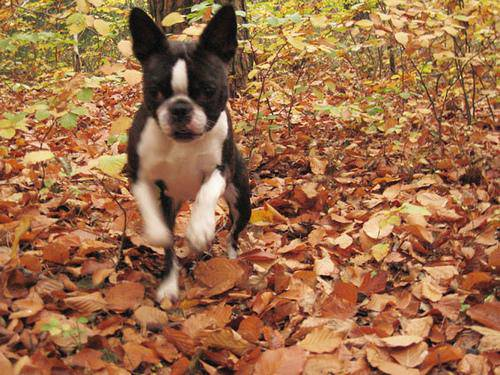

,id,breed,path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


In [ ]:
#show a random image
def show_image(image_id):
  display(Image(filename=f'train/{image_id}.jpg'))

show_image('000bec180eb18c7604dcecc8fe0dba07')

# create a new column with the path of the image
labels['path'] = labels['id'].apply(lambda x: f'train/{x}.jpg')
labels.head()


In [ ]:
# create a new column with the path of the image
labels['path'] = labels['id'].apply(lambda x: f'train/{x}.jpg')
labels.head()

,id,breed,path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


In [ ]:
breed_classes = labels['breed'].value_counts().reset_index()
breed_classes

,breed,count
0,scottish_deerhound,126
1,maltese_dog,117
2,afghan_hound,116
3,entlebucher,115
4,bernese_mountain_dog,114
...,...,...
115,golden_retriever,67
116,komondor,67
117,brabancon_griffon,67
118,eskimo_dog,66


In [ ]:
#create a list of file names
filenames = os.listdir('train')

In [ ]:
# create a list of file names with the full path
full_filenames = [os.path.join('train', f) for f in filenames]
full_filenames[:5]

['train/3773d21aa21c6fdb06a9f5980dbb6784.jpg',
 'train/330a44b4ddcd32f30fc5213dc8839318.jpg',
 'train/d94d0ab0f504e4ff8315d02259deade9.jpg',
 'train/edd8796ad2ee790f6ab20f65329007c3.jpg',
 'train/4913dfba39360e1d1489388e1a7554b8.jpg']

In [ ]:
filenames = ['train/' + fname + '.jpg' for fname in labels['id'] ]
len(filenames)

10222

Below is the 3x3 sample images. There are various dog breed images with different colors, image sizes and etc.

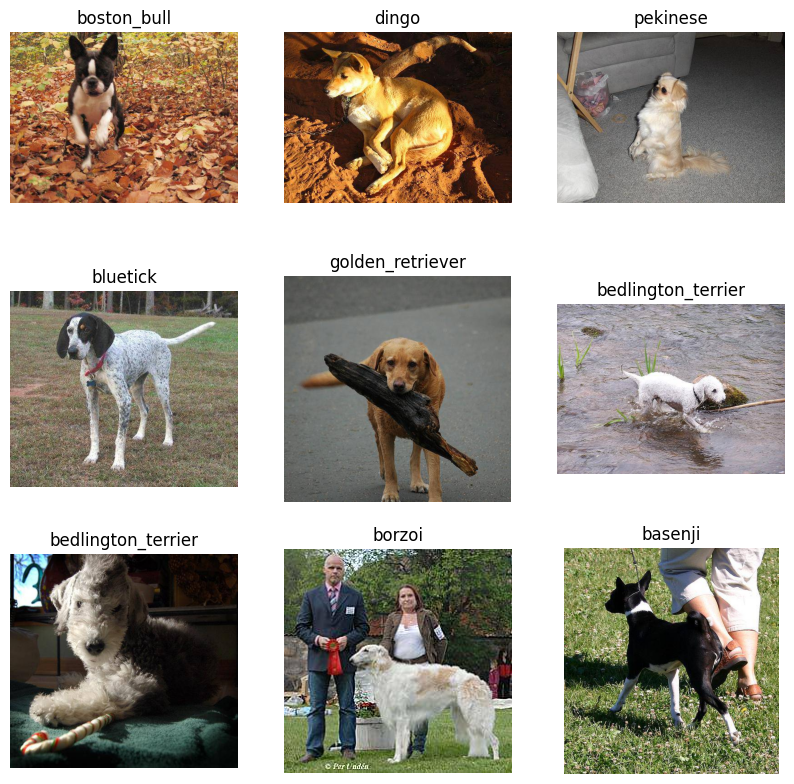

In [ ]:
# show 9 random images
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(filenames[i]))
    plt.title(labels['breed'][i])
    plt.axis('off')

plt.show()

## Data Visualization

**Plotting Bar Chart of Dog Breed**

Using pyplot, we can create the bar chart to visualize the distribution of dog breeds. From the chart below, we can see that Scottish Deerhound has the most images in our dataset, while Briard has the least images. The dog breed class has unbalanced distribution.

<ipython-input-33-e16d94504504>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(breed_classes, x='breed', y='count', palette="flare")


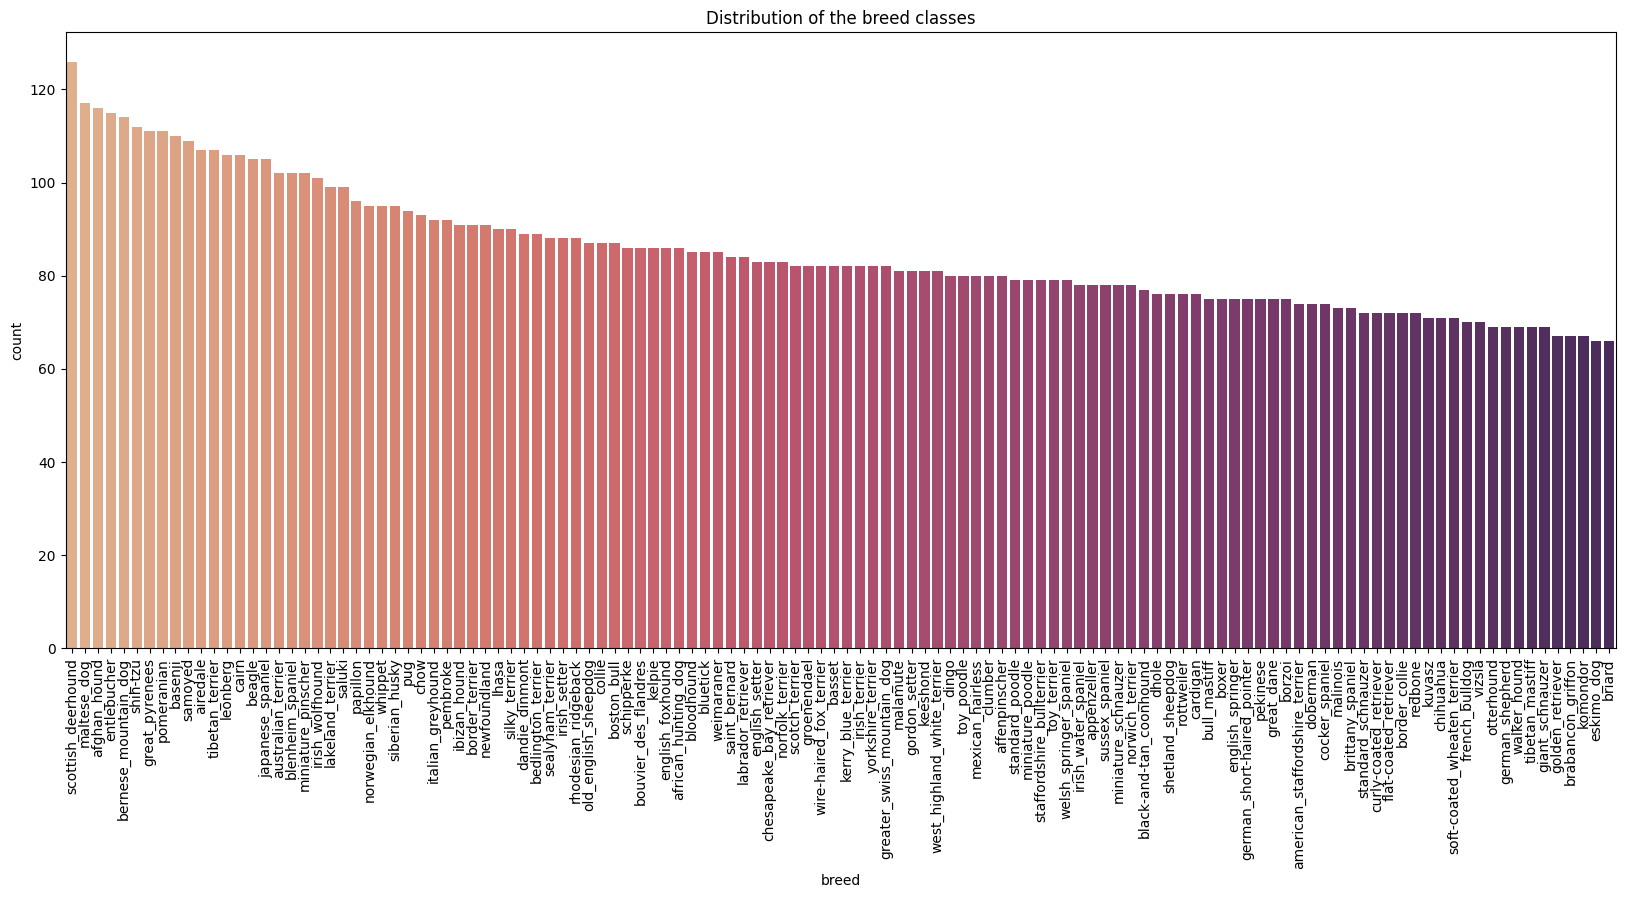

In [ ]:
# plot the distribution of breed classes
plt.figure(figsize=(20,8))
sns.barplot(breed_classes, x='breed', y='count', palette="flare")
plt.xticks(rotation=90)
plt.title("Distribution of the breed classes")
plt.show()

**Plotting Scatter Plot of Image Resolutions:**

We can create a scatter plot using matplotlib.pyplot to visualize the distribution of image resolutions (width and height) within our dataset. This plot allows us to identify relationships, patterns, or clusters in the image resolutions. By examining the scatter plot, we can gain insights into the overall image dimensions and discover any irregularities or trends.

In [ ]:
# plot image size distribution
image_sizes = [plt.imread(f).shape for f in filenames]
image_sizes = pd.DataFrame(image_sizes, columns=['height', 'width', 'channels'])
image_sizes.head()

,height,width,channels
0,375,500,3
1,375,500,3
2,375,500,3
3,344,400,3
4,500,500,3


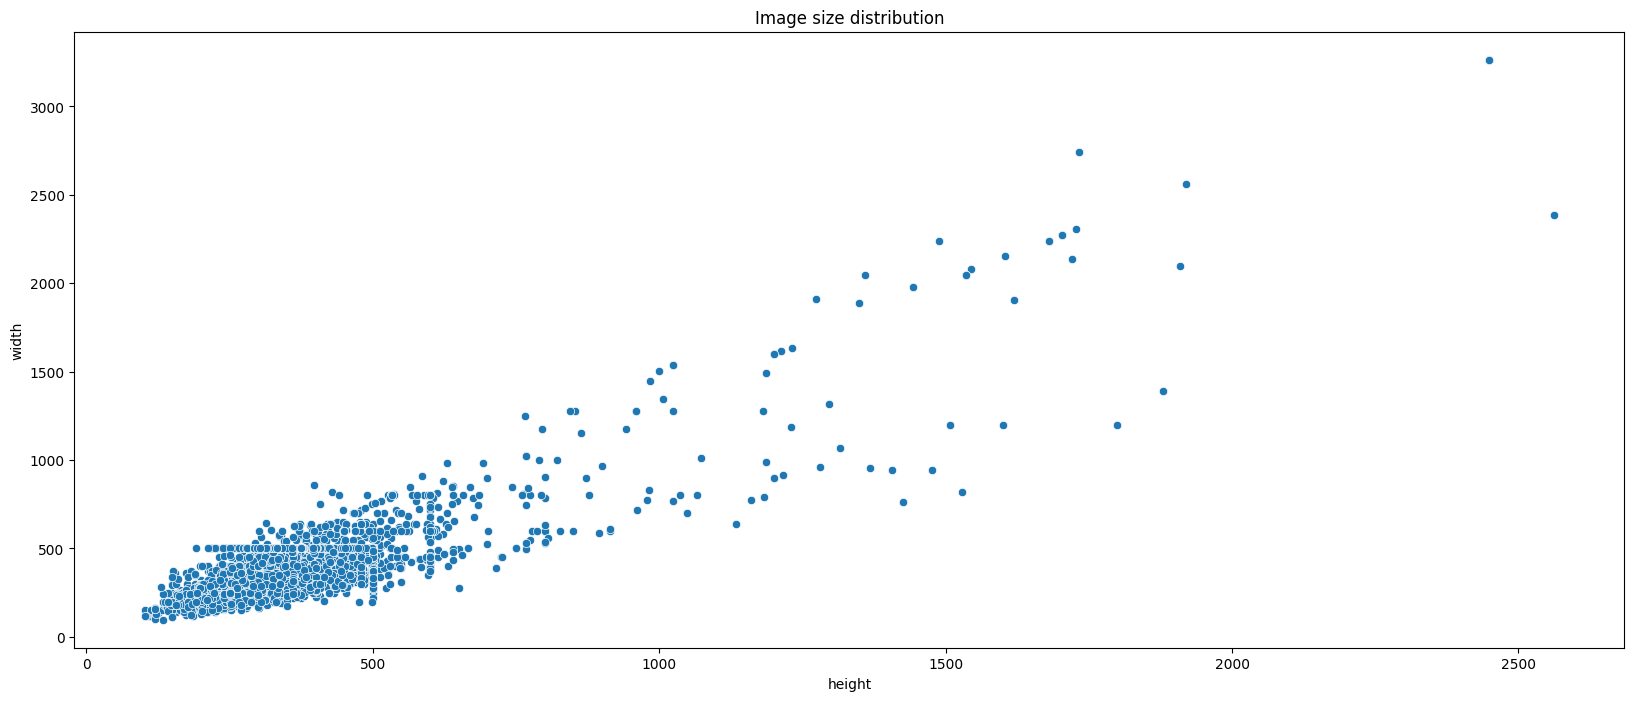

In [ ]:
#plot distribution of image sizes
plt.figure(figsize=(20,8))
sns.scatterplot(data=image_sizes, x='height', y='width')
plt.title('Image size distribution')
plt.show()

The above image shows that most images cluster height under around 600 and width under around 700.

**Plotting Histogram of Image Sizes:**

To understand the distribution of image sizes, we can create a histogram using matplotlib.pyplot. By plotting the sizes of the images (in bytes), we can gain insights into the range and frequency of different image sizes within our dataset. This visualization allows us to identify outliers or common size patterns, which is helpful for subsequent analysis. The file size has skewed to right distribution.

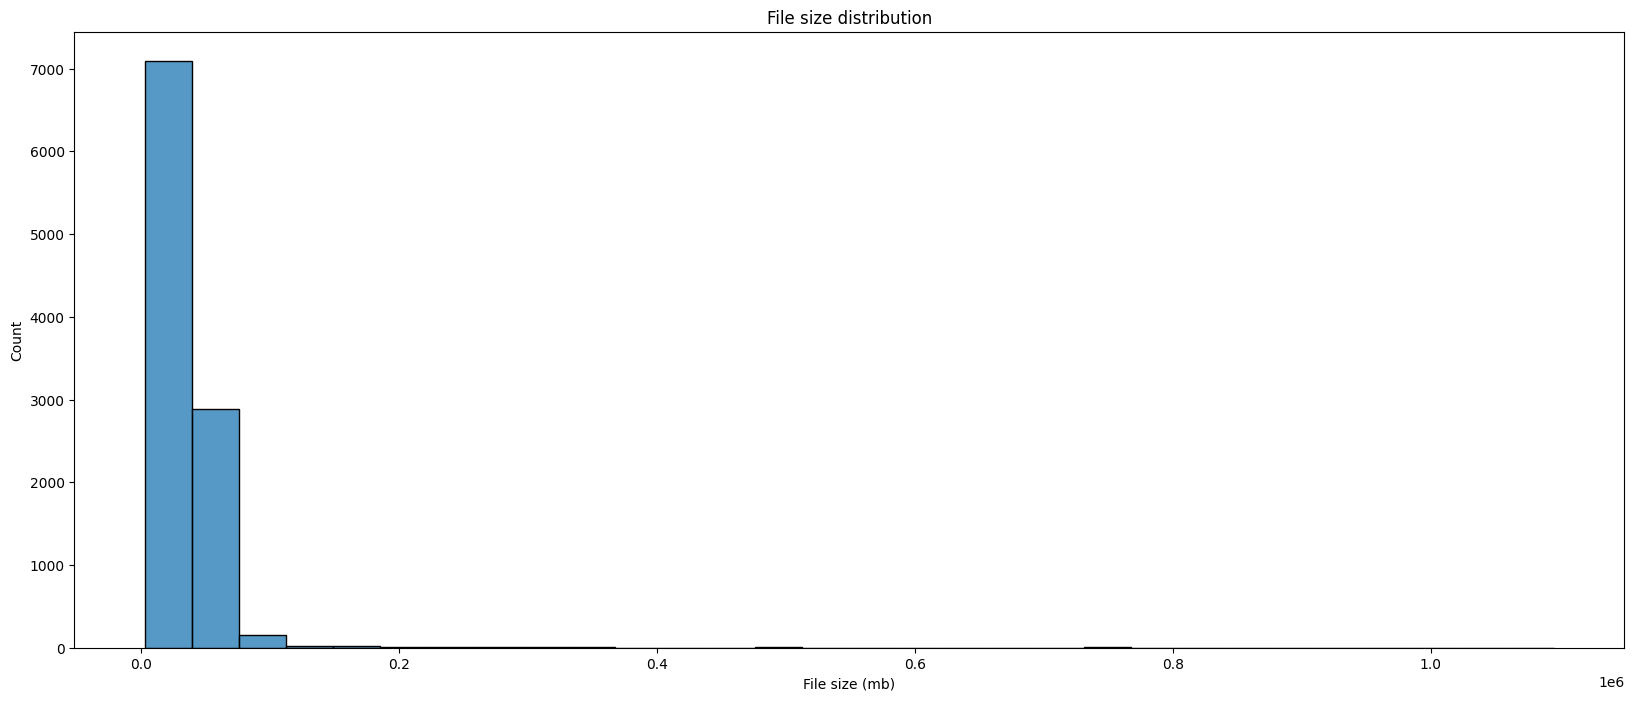

In [ ]:
# plot the distribution of file sizes
file_sizes = [os.path.getsize(f) for f in filenames]
plt.figure(figsize=(20,8))
sns.histplot(file_sizes, bins=30)
plt.title('File size distribution')
plt.xlabel('File size (mb)')
plt.ylabel('Count')
plt.show()

## 2. Data Preprocessing

To perform the classification, we did data preprocessing. We set X values to filenames and y values to breed class.

In [ ]:
# general X and y preparation
X = filenames
y = labels['breed']
batch_size = 32
img_size = 224

Using one hot encoding, we made target variables index vector.

In [ ]:
y = pd.get_dummies(y, dtype= int)
encoding_labels = y.columns
y=y.to_numpy()

Split into train and test sets with 20% test size.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

len(X_train), len(y_train), len(X_val), len(y_val)

(8177, 8177, 2045, 2045)

### Images Preprocessing

In [ ]:
#data augmentation
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2),
    RandomBrightness(0.2)
])

We created data augmentation function, however, we did not apply it since the accuracy of all models we tried were less than 10%. Then we ran models without augmentation and the accuracy was high. We checked the images and they already have various shape, colors, and etc.

The prepare_image was created. The function works reading image files, decoding, converting and resizing. It made image files suitable to classification.

In [ ]:
def prepare_image(image_path,label):
    '''
    turns an image into a tensor
    '''
    # read an image
    image = tf.io.read_file(image_path)
    # turn an image to numerical version
    image = tf.image.decode_jpeg(image, channels=3)
    # convert colours from 0-255 to 0-1
    image = tf.image.convert_image_dtype(image, tf.float32)
    # resize
    image = tf.image.resize(image, size=[img_size, img_size])

    return image, label

Then, using the create_batches function, the tensorflow dataset was made.

In [ ]:
def create_batches(X, y=None, batch_size=batch_size, valid_data=False):
    '''
    split a dataset to batches
    '''
    if valid_data:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data_batch = data.map(prepare_image).batch(batch_size)
    else:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data = data.shuffle(buffer_size=len(X))
        data_batch = data.map(prepare_image).batch(batch_size)

    return data_batch

In [ ]:
# only perform data augmentation on train set
train_data = create_batches(X_train, y_train)
valid_data = create_batches(X_val, y_val, valid_data=True)

## 3. Baseline CNN

Hyperparameter Tuning for Version 1

In [ ]:
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the model building function
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Choice('conv_1_filter', values=[32, 64, 128]),
                     kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                     activation='relu',
                     input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=hp.Choice('conv_2_filter', values=[64, 128, 256]),
                     kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(units=hp.Choice('dense_units', values=[128, 256, 512]),
                    activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(BatchNormalization())

    model.add(Dense(120, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Perform hyperparameter tuning
tuner = kt.GridSearch(build_model,
                        objective='val_accuracy',
                        max_trials=10,
                        executions_per_trial=2,
                        directory='hyperparameter_tuning',
                        project_name='breeds_classification')

tuner.search(train_data, epochs=10, validation_data=valid_data)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of filters in the first convolutional layer is {best_hps.get('conv_1_filter')},
the optimal kernel size for the first convolutional layer is {best_hps.get('conv_1_kernel')},
the optimal number of filters in the second convolutional layer is {best_hps.get('conv_2_filter')},
the optimal kernel size for the second convolutional layer is {best_hps.get('conv_2_kernel')},
and the optimal number of units in the dense layer is {best_hps.get('dense_units')}.
""")


Trial 10 Complete [00h 07m 27s]

Best val_accuracy So Far: 0.07603911682963371
Total elapsed time: 01h 46m 09s

The hyperparameter search is complete. The optimal number of filters in the first convolutional layer is 32,
the optimal kernel size for the first convolutional layer is 3,
the optimal number of filters in the second convolutional layer is 64,
the optimal kernel size for the second convolutional layer is 3,
and the optimal number of units in the dense layer is 512.



Version 1

In [ ]:
IMG_SIZE = 224

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3), kernel_regularizer=l2(0.001), padding = 'same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001), padding = 'same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(120, activation='softmax')
])


# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_data, validation_data=valid_data, epochs=10, callbacks=[early_stopping])

Epoch 1/10
256/256 [==============================] - 49s 153ms/step - loss: 6.7006 - accuracy: 0.0203 - val_loss: 7.1141 - val_accuracy: 0.0132
Epoch 2/10
256/256 [==============================] - 33s 127ms/step - loss: 5.4077 - accuracy: 0.1169 - val_loss: 6.0288 - val_accuracy: 0.0411
Epoch 3/10
256/256 [==============================] - 30s 116ms/step - loss: 3.6211 - accuracy: 0.4880 - val_loss: 6.2209 - val_accuracy: 0.0543
Epoch 4/10
256/256 [==============================] - 33s 130ms/step - loss: 1.9765 - accuracy: 0.9193 - val_loss: 6.2531 - val_accuracy: 0.0469
Epoch 5/10
256/256 [==============================] - 31s 123ms/step - loss: 1.4903 - accuracy: 0.9936 - val_loss: 6.3169 - val_accuracy: 0.0504
Epoch 6/10
256/256 [==============================] - 30s 117ms/step - loss: 1.3078 - accuracy: 0.9984 - val_loss: 5.9634 - val_accuracy: 0.0582
Epoch 7/10
256/256 [==============================] - 32s 126ms/step - loss: 1.1450 - accuracy: 0.9993 - val_loss: 5.8796 - val_ac

Plot of Train Accuracy vs Validation Accuracy for Version 1



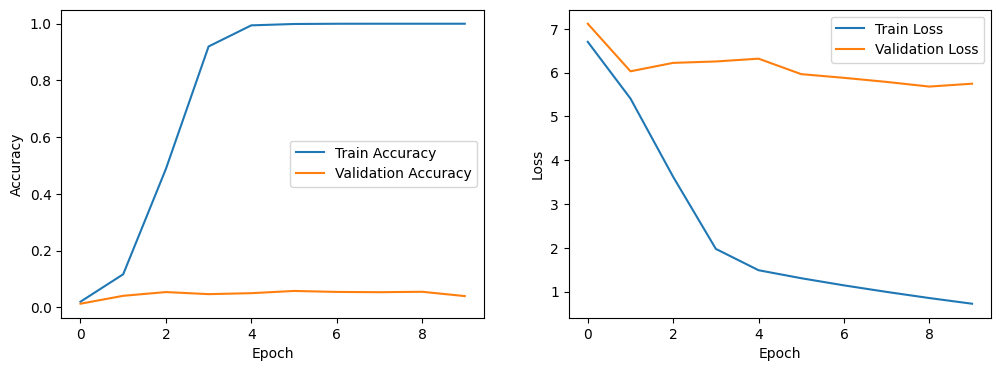

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the history
plot_history(history)


The significant amout of over fitting indicated that the model may be fitting to noise present in the images. The following adjustments were made to help reduce the overfitting:

Version 2: Simplify Above Model and Lower Learning Rate and Different Loss Function

Hyperparameter Tuning for Version 2

In [ ]:
!pip install keras-tuner

In [ ]:
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the model building function
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Choice('conv_1_filter', values=[32, 64, 128]),
                     kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                     activation='relu',
                     input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(units=hp.Choice('dense_units', values=[128, 256, 512]),
                    activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(BatchNormalization())

    model.add(Dense(120, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.000001),
                  loss='categorical_focal_crossentropy',
                  metrics=['accuracy'])

    return model

# Perform hyperparameter tuning
tuner = kt.GridSearch(build_model,
                        objective='val_accuracy',
                        max_trials=5,
                        executions_per_trial=1,
                        directory='hyperparameter_tuning',
                        project_name='breeds_classification')

tuner.search(train_data, epochs=10, validation_data=valid_data)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of filters in the first convolutional layer is {best_hps.get('conv_1_filter')},
the optimal kernel size for the first convolutional layer is {best_hps.get('conv_1_kernel')},
and the optimal number of units in the dense layer is {best_hps.get('dense_units')}.
""")


Trial 5 Complete [00h 06m 15s]
val_accuracy: 0.042053788900375366

Best val_accuracy So Far: 0.055745720863342285
Total elapsed time: 00h 37m 34s

The hyperparameter search is complete. The optimal number of filters in the first convolutional layer is 32,
the optimal kernel size for the first convolutional layer is 3,
and the optimal number of units in the dense layer is 512.



Version 2 After Hyperparameter Tuning

In [ ]:
IMG_SIZE = 224

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3), kernel_regularizer=l2(0.001), padding = 'same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(120, activation='softmax')
])


# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.000001), loss='categorical_focal_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_data, validation_data=valid_data, epochs=10, callbacks=[early_stopping])

Epoch 1/10
256/256 [==============================] - 56s 192ms/step - loss: 2.4898 - accuracy: 0.0126 - val_loss: 2.1984 - val_accuracy: 0.0156
Epoch 2/10
256/256 [==============================] - 34s 132ms/step - loss: 2.2817 - accuracy: 0.0323 - val_loss: 2.1621 - val_accuracy: 0.0264
Epoch 3/10
256/256 [==============================] - 32s 124ms/step - loss: 2.1591 - accuracy: 0.0561 - val_loss: 2.1622 - val_accuracy: 0.0298
Epoch 4/10
256/256 [==============================] - 35s 137ms/step - loss: 2.0522 - accuracy: 0.0849 - val_loss: 2.1531 - val_accuracy: 0.0401
Epoch 5/10
256/256 [==============================] - 34s 135ms/step - loss: 1.9477 - accuracy: 0.1258 - val_loss: 2.1397 - val_accuracy: 0.0372
Epoch 6/10
256/256 [==============================] - 32s 125ms/step - loss: 1.8362 - accuracy: 0.1740 - val_loss: 2.1316 - val_accuracy: 0.0381
Epoch 7/10
256/256 [==============================] - 31s 120ms/step - loss: 1.7423 - accuracy: 0.2287 - val_loss: 2.1323 - val_ac

Plot of Train Accuracy vs Validation Accuracy for Version 2 after Hyperparameter Tuning


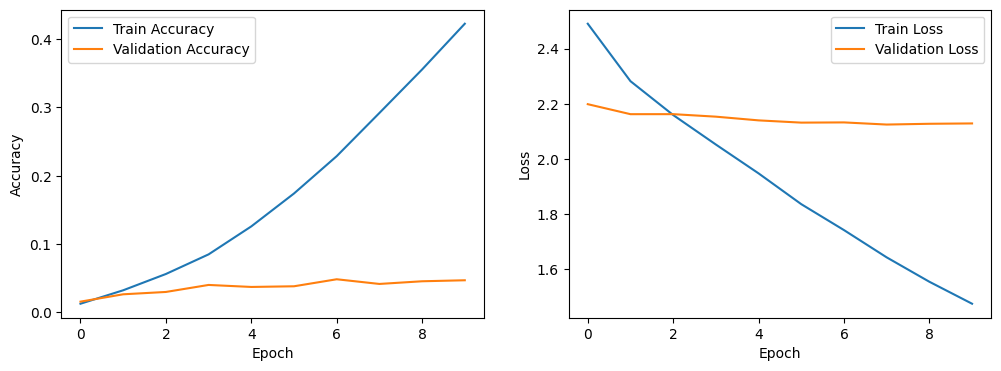

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the history
plot_history(history)


The overfitting of the model has improved but the accuracy is still very low, so we decided to implement transfer learning instead.

## 4. Transfer Learning

For this part, we're going to introduce three pre-trained models and perform the fine tuning.

Transfer learning is a powerful technique in deep learning that allows us to leverage pre-trained models on larger datasets to improve performance on our specific task.

* Pre-trained on Large Dataset:
Models like InceptionV3 are pre-trained on large datasets like ImageNet, which has over a million images of 1000 classes. These models have already learned a wide variety of features, which can be useful for many image recognition tasks.

* Learned Hierarchical Features: Deep learning models learn hierarchical features. Lower layers learn simple features like edges and textures, while deeper layers learn more complex, abstract features. By using a pre-trained model, you're starting with these learned features rather than starting from scratch.

* Saves Training Time: Training a deep learning model from scratch requires a lot of computational resources and time. With transfer learning, starting with a model that has already been trained can save a significant amount of time and resources.

In [ ]:
#set breed count as the neurons at last softmax layer
breed_count = len(encoding_labels)

### InceptionResNetV2 Model

InceptionResNetV2 model is a convolutional neural network that is widely used in tasks that involve image and video processing. The model combines the Inception and ResNet architectures to get the best of both worlds. It uses Inception modules to learn powerful features, and residual connections to train a deep network. It is used in a wide range of applications, including image classification, object detection, and more.

#### Freeze all layers

First, we freeze all the layers for the InceptionResNetV2 model.

In [ ]:
base_model = InceptionResNetV2(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.7)(x)

predictions = Dense(breed_count, activation='softmax')(x)

model = Model(base_model.input, outputs = predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy',mode='max',patience=5,restore_best_weights=True)
inception_hist1 = model.fit(train_data,
                    epochs=20,
                    validation_data=valid_data,
                    callbacks = [early_stopping])

Epoch 1/20
256/256 [==============================] - 91s 276ms/step - loss: 2.4897 - accuracy: 0.5235 - val_loss: 0.7698 - val_accuracy: 0.8337
Epoch 2/20
256/256 [==============================] - 65s 254ms/step - loss: 0.9511 - accuracy: 0.8020 - val_loss: 0.7001 - val_accuracy: 0.8328
Epoch 3/20
256/256 [==============================] - 66s 256ms/step - loss: 0.8115 - accuracy: 0.8226 - val_loss: 0.6892 - val_accuracy: 0.8342
Epoch 4/20
256/256 [==============================] - 66s 256ms/step - loss: 0.7481 - accuracy: 0.8328 - val_loss: 0.6867 - val_accuracy: 0.8357
Epoch 5/20
256/256 [==============================] - 65s 254ms/step - loss: 0.6921 - accuracy: 0.8388 - val_loss: 0.6871 - val_accuracy: 0.8352
Epoch 6/20
256/256 [==============================] - 65s 255ms/step - loss: 0.6342 - accuracy: 0.8547 - val_loss: 0.6973 - val_accuracy: 0.8308
Epoch 7/20
256/256 [==============================] - 66s 256ms/step - loss: 0.6194 - accuracy: 0.8543 - val_loss: 0.6985 - val_ac

In [ ]:
# Training/Test accuracy
train_acc_incep1 = inception_hist1.history['accuracy']
train_loss_incep1 = inception_hist1.history['loss']
test_acc_incep1 = inception_hist1.history['val_accuracy']
test_loss_incep1 = inception_hist1.history['val_loss']

# Find the epoch with the highest accuracy
best_epoch_incep1 = test_acc_incep1.index(max(test_acc_incep1)) + 1
best_train_acc_incep1 = train_acc_incep1[best_epoch_incep1 - 1]
best_train_loss_incep1 = test_loss_incep1[best_epoch_incep1 - 1]
best_test_acc_incep1 = test_acc_incep1[best_epoch_incep1 - 1]
best_test_loss_incep1 = test_loss_incep1[best_epoch_incep1 - 1]

# Print the best epoch and corresponding training/test accuracy and loss
print(f"Best epoch: {best_epoch_incep1}")
print(f"Best training accuracy at epoch {best_epoch_incep1}: {best_train_acc_incep1}")
print(f"Best training loss at epoch {best_epoch_incep1}: {best_train_loss_incep1}")
print(f"Best test accuracy at epoch {best_epoch_incep1}: {best_test_acc_incep1}")
print(f"Best test loss at epoch {best_epoch_incep1}: {best_test_loss_incep1}")


Best epoch: 11
Best training accuracy at epoch 11: 0.8770942687988281
Best training loss at epoch 11: 0.697475016117096
Best test accuracy at epoch 11: 0.8386307954788208
Best test loss at epoch 11: 0.697475016117096


The train accuracy is round 87.7%, while test accuracy reached 83.8%. The result has improved compared to the baseline CNN.

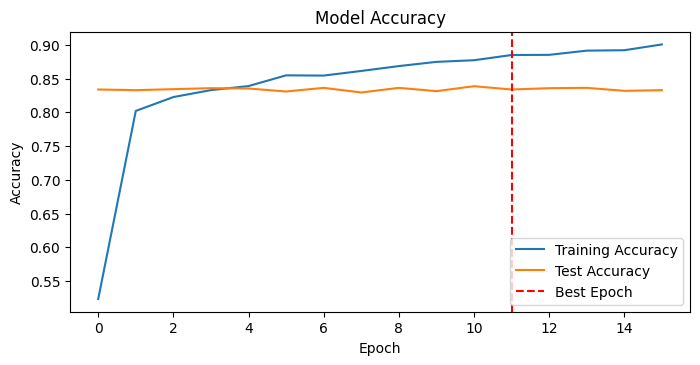

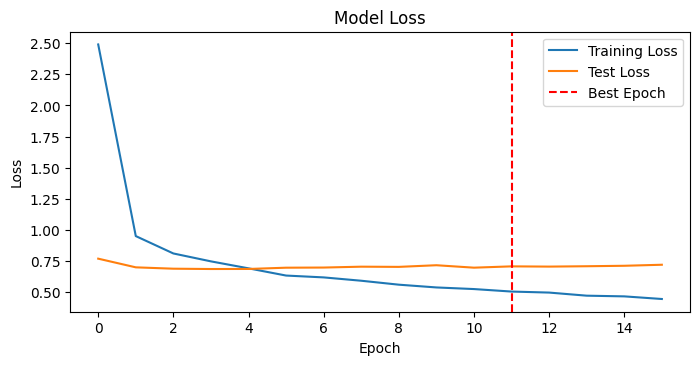

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(2,1, 1)
plt.plot(train_acc_incep1, label='Training Accuracy')
plt.plot(test_acc_incep1, label='Test Accuracy')
plt.axvline(x=best_epoch_incep1 -1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.figure(figsize=(8, 8))

plt.subplot(2,1,1)
plt.plot(train_loss_incep1, label='Training Loss')
plt.plot(test_loss_incep1, label='Test Loss')
plt.axvline(x=best_epoch_incep1 -1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


**Adjust Dropout Rate from 0.7 to 0.5**

In [ ]:
# create a model
base_model = InceptionResNetV2(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(breed_count, activation='softmax')(x)

model = Model(base_model.input, outputs = predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy',mode='max',patience=3,restore_best_weights=True)
inception_hist = model.fit(train_data,
                    epochs=20,
                    validation_data=valid_data,
                    callbacks = [early_stopping])

Epoch 1/20
256/256 [==============================] - 84s 273ms/step - loss: 1.8709 - accuracy: 0.6488 - val_loss: 0.7522 - val_accuracy: 0.8240
Epoch 2/20
256/256 [==============================] - 66s 259ms/step - loss: 0.7453 - accuracy: 0.8367 - val_loss: 0.7163 - val_accuracy: 0.8289
Epoch 3/20
256/256 [==============================] - 56s 217ms/step - loss: 0.6592 - accuracy: 0.8477 - val_loss: 0.6978 - val_accuracy: 0.8279
Epoch 4/20
256/256 [==============================] - 65s 255ms/step - loss: 0.5853 - accuracy: 0.8682 - val_loss: 0.7045 - val_accuracy: 0.8313
Epoch 5/20
256/256 [==============================] - 66s 256ms/step - loss: 0.5303 - accuracy: 0.8765 - val_loss: 0.7120 - val_accuracy: 0.8259
Epoch 6/20
256/256 [==============================] - 65s 255ms/step - loss: 0.5104 - accuracy: 0.8814 - val_loss: 0.7023 - val_accuracy: 0.8274
Epoch 7/20
256/256 [==============================] - 56s 219ms/step - loss: 0.4654 - accuracy: 0.8916 - val_loss: 0.7113 - val_ac

In [ ]:
# Training/Test accuracy
train_acc_incep = inception_hist.history['accuracy']
train_loss_incep = inception_hist.history['loss']
test_acc_incep = inception_hist.history['val_accuracy']
test_loss_incep = inception_hist.history['val_loss']

# Find the epoch with the highest accuracy
best_epoch_incep = test_acc_incep.index(max(test_acc_incep)) + 1
best_train_acc_incep = train_acc_incep[best_epoch_incep - 1]
best_train_loss_incep = test_loss_incep[best_epoch_incep - 1]
best_test_acc_incep = test_acc_incep[best_epoch_incep - 1]
best_test_loss_incep = test_loss_incep[best_epoch_incep - 1]

# Print the best epoch and corresponding training/test accuracy and loss
print(f"Best epoch: {best_epoch_incep}")
print(f"Best training accuracy at epoch {best_epoch_incep}: {best_train_acc_incep}")
print(f"Best training loss at epoch {best_epoch_incep}: {best_train_loss_incep}")
print(f"Best test accuracy at epoch {best_epoch_incep}: {best_test_acc_incep}")
print(f"Best test loss at epoch {best_epoch_incep}: {best_test_loss_incep}")

Best epoch: 4
Best training accuracy at epoch 4: 0.8681668043136597
Best training loss at epoch 4: 0.7045498490333557
Best test accuracy at epoch 4: 0.8312958478927612
Best test loss at epoch 4: 0.7045498490333557


We can see the test accuracy has dropped to 83.1%.

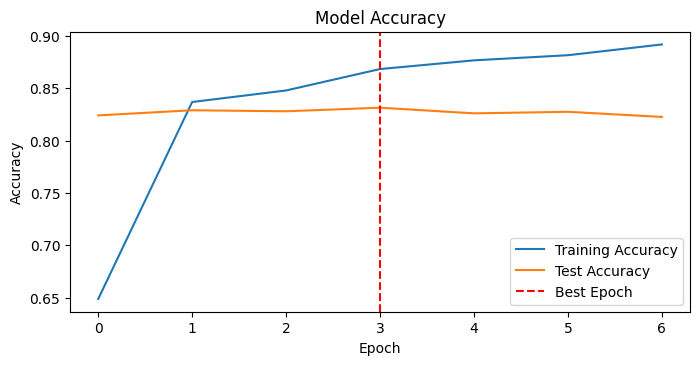

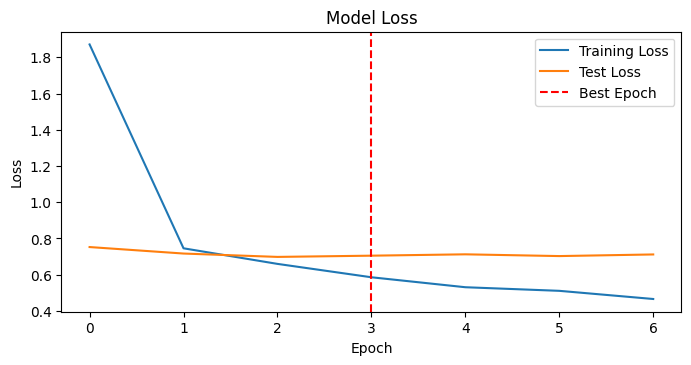

In [ ]:
# Plot training & test accuracy values
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(train_acc_incep, label='Training Accuracy')
plt.plot(test_acc_incep, label='Test Accuracy')
plt.axvline(x=best_epoch_incep -1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(train_loss_incep, label='Training Loss')
plt.plot(test_loss_incep, label='Test Loss')
plt.axvline(x=best_epoch_incep -1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

#### Freeze 650 layers

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  780


In [ ]:
fine_tune_at = len(train_acc_incep)-1

There are 780 layers in the InceptionResNetV2 base model, so we decided to only freeze the first 650 layers and unfreeze the rest layers. Additionally, we decreased the learning rate from 0.0001 to 0.00001 in order to reduce overfitting.

In [ ]:
# fine-tuning
k=650

for layer in base_model.layers[:k]:
  layer.trainable = False
# unfreeze the rest layers
for layer in base_model.layers[k:]:
  layer.trainable = True

#decrease learning rate to reduce overfitting
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
inception_hist_fine = model.fit(train_data,
                    epochs=20,
                    validation_data=valid_data,
                    callbacks = [early_stopping])


Epoch 1/20
256/256 [==============================] - 109s 289ms/step - loss: 0.6728 - accuracy: 0.8451 - val_loss: 0.6972 - val_accuracy: 0.8298
Epoch 2/20
256/256 [==============================] - 75s 295ms/step - loss: 0.5668 - accuracy: 0.8647 - val_loss: 0.6954 - val_accuracy: 0.8264
Epoch 3/20
256/256 [==============================] - 81s 315ms/step - loss: 0.5087 - accuracy: 0.8876 - val_loss: 0.6918 - val_accuracy: 0.8303
Epoch 4/20
256/256 [==============================] - 77s 301ms/step - loss: 0.4522 - accuracy: 0.8997 - val_loss: 0.6975 - val_accuracy: 0.8328
Epoch 5/20
256/256 [==============================] - 75s 293ms/step - loss: 0.4132 - accuracy: 0.9133 - val_loss: 0.6976 - val_accuracy: 0.8347
Epoch 6/20
256/256 [==============================] - 79s 307ms/step - loss: 0.3688 - accuracy: 0.9263 - val_loss: 0.7111 - val_accuracy: 0.8318
Epoch 7/20
256/256 [==============================] - 75s 293ms/step - loss: 0.3401 - accuracy: 0.9404 - val_loss: 0.7204 - val_a

In [ ]:
# Training/Test accuracy
train_acc_incep_fine = inception_hist_fine.history['accuracy']
train_loss_incep_fine = inception_hist_fine.history['loss']
test_acc_incep_fine = inception_hist_fine.history['val_accuracy']
test_loss_incep_fine = inception_hist_fine.history['val_loss']

# Find the epoch with the highest accuracy
best_epoch_incep_fine = test_acc_incep_fine.index(max(test_acc_incep_fine)) + 1
best_train_acc_incep_fine = train_acc_incep_fine[best_epoch_incep_fine - 1]
best_train_loss_incep_fine = test_loss_incep_fine[best_epoch_incep_fine - 1]
best_test_acc_incep_fine = test_acc_incep_fine[best_epoch_incep_fine - 1]
best_test_loss_incep_fine = test_loss_incep_fine[best_epoch_incep_fine - 1]

# Print the best epoch and corresponding training/test accuracy and loss
print(f"Best epoch: {best_epoch_incep_fine}")
print(f"Best training accuracy at epoch {best_epoch_incep_fine}: {best_train_acc_incep_fine}")
print(f"Best training loss at epoch {best_epoch_incep_fine}: {best_train_loss_incep_fine}")
print(f"Best test accuracy at epoch {best_epoch_incep_fine}: {best_test_acc_incep_fine}")
print(f"Best test loss at epoch {best_epoch_incep_fine}: {best_test_loss_incep_fine}")

Best epoch: 8
Best training accuracy at epoch 8: 0.9485141038894653
Best training loss at epoch 8: 0.7187890410423279
Best test accuracy at epoch 8: 0.835696816444397
Best test loss at epoch 8: 0.7187890410423279


Our test accuracy increased a little to 83.6%, but it's still lower than the first model with dropout rate of 0.7.

In [ ]:
train_acc = train_acc_incep + inception_hist_fine.history['accuracy']
test_acc = test_acc_incep + inception_hist_fine.history['val_accuracy']

train_loss = train_loss_incep + inception_hist_fine.history['loss']
test_loss = test_loss_incep + inception_hist_fine.history['val_loss']

Below are plots of model accuracy and model loss before and after fine tuning.

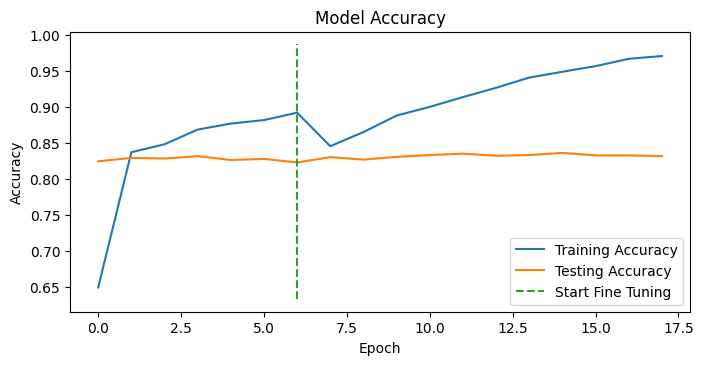

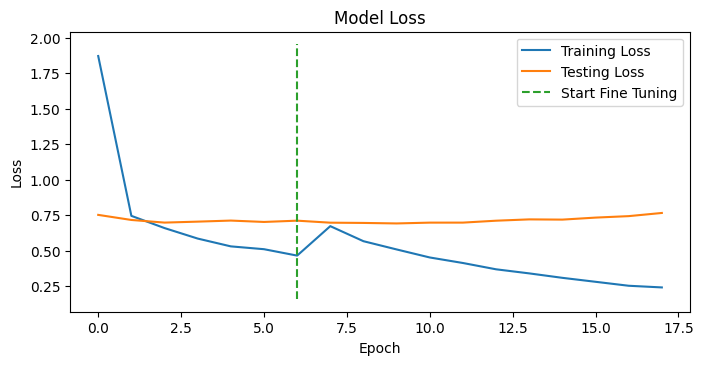

In [ ]:
#plot the training and test accuracy
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Testing Accuracy')
#plt.axvline(x=best_epoch_incep_fine -1, color='r', linestyle='--', label='Best Epoch')
plt.plot([fine_tune_at,fine_tune_at],
          plt.ylim(), label='Start Fine Tuning',linestyle='--')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
#plt.axvline(x=best_epoch_incep_fine -1, color='r', linestyle='--', label='Best Epoch')
plt.plot([fine_tune_at,fine_tune_at],
          plt.ylim(), label='Start Fine Tuning',linestyle='--')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

### MobileNetV2 Model

Since the release of AlexNet, neural networks have increasingly grown deeper and more complex to improve performance. However, such complex models often lack optimization for mobile environments, where computational efficiency, model size, and latency are crucial.

To make deep learning models more compact, researchers have explored methods such as compressing trained models and designing efficient network architectures. MobileNet, developed by Google in 2017, exemplifies an approach that achieves compactness through an efficient design.

While many lightweight models like SqueezeNet have primarily focused on reducing model size, sometimes overlooking latency, MobileNet stands out by emphasizing reductions in both model size and latency.

To achieve efficient network configuration with reduced model size and latency, MobileNet utilizes Depthwise Separable Convolutions, a concept from the Xception architecture. It also introduces hyperparameters to adjust the model's size to better fit specific hardware capabilities.

Using MobileNetV2, 6 models were created: freezing all layers with dropout rate 0.5 and 0.1, freezing 100 layers with dropout rate 0.5 and 0.1 and unfreezing all layers with dropout rate 0.5 and 0.1.

In [ ]:
# Load a pretrained MobileNetV2 model without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

len(base_model.layers)

154

There were total 154 layers in the base model.

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_8[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

#### Freeze all layers

**Dropout rate = 0.5**

To the base model, 6 layers were added, so 160 layers were in the model. The model used Adam optimization with 0.001 learning rate. The categorical focal cross entropy loss function was used.

In [ ]:
# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(breed_count, activation='softmax')(x)

# Create the new model
model = Model(base_model.input, outputs = predictions)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_focal_crossentropy', metrics=['accuracy'])

print(len(model.layers))

160


In [ ]:
# Model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_9[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

The early stopping was also applied with 10 patience. Epoch 20 was chosen to train the model.

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=2)

# Train the entire model
epochs = 20
history1 = model.fit(train_data, validation_data=valid_data, epochs=epochs, callbacks=[early_stopping])

Epoch 1/20
256/256 [==============================] - 33s 89ms/step - loss: 0.4749 - accuracy: 0.5264 - val_loss: 0.2474 - val_accuracy: 0.7076
Epoch 2/20
256/256 [==============================] - 20s 79ms/step - loss: 0.2269 - accuracy: 0.7411 - val_loss: 0.2328 - val_accuracy: 0.7271
Epoch 3/20
256/256 [==============================] - 26s 102ms/step - loss: 0.1838 - accuracy: 0.7917 - val_loss: 0.2358 - val_accuracy: 0.7296
Epoch 4/20
256/256 [==============================] - 19s 73ms/step - loss: 0.1575 - accuracy: 0.8314 - val_loss: 0.2407 - val_accuracy: 0.7183
Epoch 5/20
256/256 [==============================] - 19s 73ms/step - loss: 0.1417 - accuracy: 0.8562 - val_loss: 0.2279 - val_accuracy: 0.7359
Epoch 6/20
256/256 [==============================] - 19s 73ms/step - loss: 0.1304 - accuracy: 0.8738 - val_loss: 0.2264 - val_accuracy: 0.7438
Epoch 7/20
256/256 [==============================] - 21s 82ms/step - loss: 0.1272 - accuracy: 0.8773 - val_loss: 0.2330 - val_accuracy

The model stopped learning at the 17th epoch, and the best epoch was the 7th.

In [ ]:
# Training/Test accuracy
train_acc1 = history1.history['accuracy']
train_loss1 = history1.history['loss']
test_acc1 = history1.history['val_accuracy']
test_loss1 = history1.history['val_loss']

# Find the epoch with the lowest test loss
best_epoch1 = test_acc1.index(max(test_acc1)) + 1
best_train_acc1 = train_acc1[best_epoch1 - 1]
best_train_loss1 = train_loss1[best_epoch1 - 1]
best_test_acc1 = test_acc1[best_epoch1 - 1]
best_test_loss1 = test_loss1[best_epoch1 - 1]

# Print the best epoch and corresponding training/test accuracy and loss
print(f"Best epoch: {best_epoch1}")
print(f"Best training accuracy at epoch {best_epoch1}: {best_train_acc1}")
print(f"Best training loss at epoch {best_epoch1}: {best_train_loss1}")
print(f"Best test accuracy at epoch {best_epoch1}: {best_test_acc1}")
print(f"Best test loss at epoch {best_epoch1}: {best_test_loss1}")

Best epoch: 7
Best training accuracy at epoch 7: 0.8773388862609863
Best training loss at epoch 7: 0.127243772149086
Best test accuracy at epoch 7: 0.7462102770805359
Best test loss at epoch 7: 0.2329946756362915


The training and test accuracy at 7th epoch were about 88% and 75%. The training and test loss were about 0.13 and 0.23.

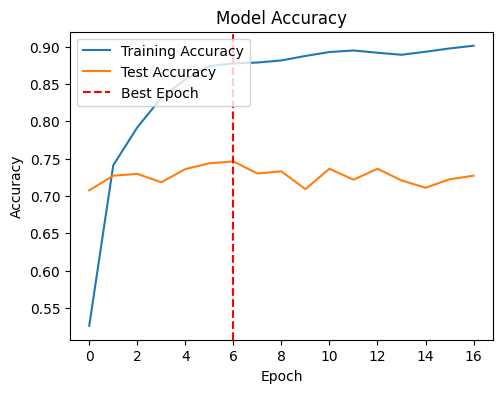

In [ ]:
# Plot training & test accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc1, label='Training Accuracy')
plt.plot(test_acc1, label='Test Accuracy')
plt.axvline(x=best_epoch1 - 1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

The above plot showed the model accuracy by epoch. The training accuracy kept increasing but test accuracy had fluctuation trend around 73%.

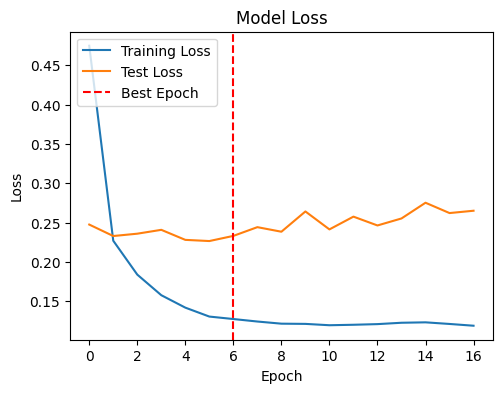

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss1, label='Training Loss')
plt.plot(test_loss1, label='Test Loss')
plt.axvline(x=best_epoch1 - 1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

The loss plot by epoch also showed the same trend. The training loss kept decreasing but test loss had fluctuation trend around 0.25 and increased at the end. As a result, the model overfitted the data.

**Dropout rate = 0.1**

The model with dropout rate of 0.1 and freezing all layers was created. It had the same conditions but dropout rate.

In [ ]:
# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

predictions = Dense(breed_count, activation='softmax')(x)

# Create the new model
model = Model(base_model.input, outputs = predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_focal_crossentropy', metrics=['accuracy'])

print(len(model.layers))

160


In [ ]:
# Model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_10[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=2)

# Train the entire model
epochs = 20
history2 = model.fit(train_data, validation_data=valid_data, epochs=epochs, callbacks=[early_stopping])

Epoch 1/20
256/256 [==============================] - 25s 85ms/step - loss: 1.4736 - accuracy: 0.3285 - val_loss: 1.0993 - val_accuracy: 0.6161
Epoch 2/20
256/256 [==============================] - 19s 73ms/step - loss: 0.9422 - accuracy: 0.6982 - val_loss: 0.8659 - val_accuracy: 0.7105
Epoch 3/20
256/256 [==============================] - 21s 81ms/step - loss: 0.7855 - accuracy: 0.7779 - val_loss: 0.7736 - val_accuracy: 0.7281
Epoch 4/20
256/256 [==============================] - 25s 98ms/step - loss: 0.6831 - accuracy: 0.8296 - val_loss: 0.7068 - val_accuracy: 0.7413
Epoch 5/20
256/256 [==============================] - 21s 82ms/step - loss: 0.6037 - accuracy: 0.8685 - val_loss: 0.6517 - val_accuracy: 0.7487
Epoch 6/20
256/256 [==============================] - 20s 79ms/step - loss: 0.5330 - accuracy: 0.9023 - val_loss: 0.5992 - val_accuracy: 0.7521
Epoch 7/20
256/256 [==============================] - 19s 74ms/step - loss: 0.4714 - accuracy: 0.9259 - val_loss: 0.5508 - val_accuracy:

Among 20 epochs, the best epoch was 9 and the model early stopped at the 19th epoch.

In [ ]:
# Training/Test accuracy
train_acc2 = history2.history['accuracy']
train_loss2 = history2.history['loss']
test_acc2 = history2.history['val_accuracy']
test_loss2 = history2.history['val_loss']

# Find the epoch with the lowest test loss
best_epoch2 = test_acc2.index(max(test_acc2)) + 1
best_train_acc2 = train_acc2[best_epoch2 - 1]
best_train_loss2 = train_loss2[best_epoch2 - 1]
best_test_acc2 = test_acc2[best_epoch2 - 1]
best_test_loss2 = test_loss2[best_epoch2 - 1]

# Print the best epoch and corresponding training/test accuracy and loss
print(f"Best epoch: {best_epoch2}")
print(f"Best training accuracy at epoch {best_epoch2}: {best_train_acc2}")
print(f"Best training loss at epoch {best_epoch2}: {best_train_loss2}")
print(f"Best test accuracy at epoch {best_epoch2}: {best_test_acc2}")
print(f"Best test loss at epoch {best_epoch2}: {best_test_loss2}")

Best epoch: 9
Best training accuracy at epoch 9: 0.9651461243629456
Best training loss at epoch 9: 0.36326804757118225
Best test accuracy at epoch 9: 0.7540342211723328
Best test loss at epoch 9: 0.46477317810058594


The best training and test accuracy were about 97% and 75%. The training and test loss were about 0.36 and 0.46.

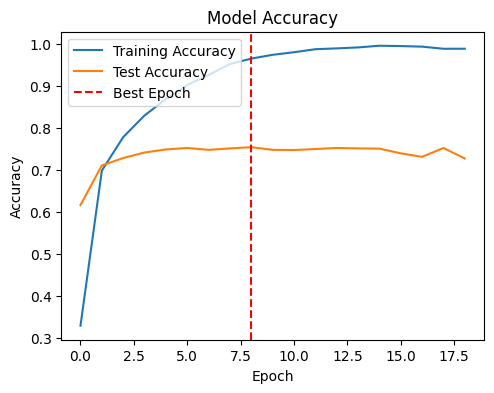

In [ ]:
# Plot training & test accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc2, label='Training Accuracy')
plt.plot(test_acc2, label='Test Accuracy')
plt.axvline(x=best_epoch2 - 1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

The training accuracy had increasing trend. However, test accuracy increased at first and had stable trend.

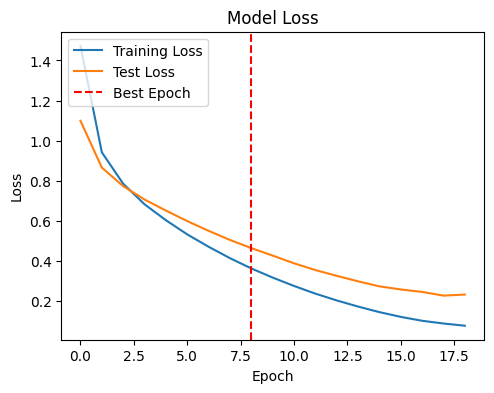

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss2, label='Training Loss')
plt.plot(test_loss2, label='Test Loss')
plt.axvline(x=best_epoch2 - 1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

The loss function showed decreasing trend both training and test data. The test loss slightly increased at the end.

#### Freeze 100 layers

**Dropout rate = 0.5**

Then a model with dropout rate of 0.5 and freezing 100 layers was created.

In [ ]:
# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Unfreeze some layers of the base model
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Fine-tune remaining layers
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Add new classification layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(breed_count, activation='softmax')(x)

# Create the new model
model = Model(base_model.input, outputs = predictions)

model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_focal_crossentropy', metrics=['accuracy'])

print(len(model.layers))

160


In [ ]:
# Model summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_11[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=2)

# epoch
epochs = 20

history3 = model.fit(train_data, validation_data=valid_data, epochs=epochs, callbacks=[early_stopping])

Epoch 1/20
256/256 [==============================] - 42s 118ms/step - loss: 2.0418 - accuracy: 0.0148 - val_loss: 1.8453 - val_accuracy: 0.0425
Epoch 2/20
256/256 [==============================] - 22s 84ms/step - loss: 1.8711 - accuracy: 0.0463 - val_loss: 1.6668 - val_accuracy: 0.1643
Epoch 3/20
256/256 [==============================] - 21s 83ms/step - loss: 1.7059 - accuracy: 0.1141 - val_loss: 1.4932 - val_accuracy: 0.2998
Epoch 4/20
256/256 [==============================] - 21s 81ms/step - loss: 1.5570 - accuracy: 0.2039 - val_loss: 1.3493 - val_accuracy: 0.4015
Epoch 5/20
256/256 [==============================] - 23s 91ms/step - loss: 1.4300 - accuracy: 0.2946 - val_loss: 1.2399 - val_accuracy: 0.4738
Epoch 6/20
256/256 [==============================] - 24s 93ms/step - loss: 1.3267 - accuracy: 0.3719 - val_loss: 1.1626 - val_accuracy: 0.5267
Epoch 7/20
256/256 [==============================] - 23s 91ms/step - loss: 1.2476 - accuracy: 0.4295 - val_loss: 1.1054 - val_accuracy

In [ ]:
# Training/Test accuracy
train_acc3 = history3.history['accuracy']
train_loss3 = history3.history['loss']
test_acc3 = history3.history['val_accuracy']
test_loss3 = history3.history['val_loss']

# Find the epoch with the lowest test loss
best_epoch3 = test_acc3.index(max(test_acc3)) + 1
best_train_acc3 = train_acc3[best_epoch3 - 1]
best_train_loss3 = train_loss3[best_epoch3 - 1]
best_test_acc3 = test_acc3[best_epoch3 - 1]
best_test_loss3 = test_loss3[best_epoch3 - 1]

# Print the best epoch and corresponding training/test accuracy and loss
print(f"Best epoch: {best_epoch3}")
print(f"Best training accuracy at epoch {best_epoch3}: {best_train_acc3}")
print(f"Best training loss at epoch {best_epoch3}: {best_train_loss3}")
print(f"Best test accuracy at epoch {best_epoch3}: {best_test_acc3}")
print(f"Best test loss at epoch {best_epoch3}: {best_test_loss3}")

Best epoch: 19
Best training accuracy at epoch 19: 0.7437935471534729
Best training loss at epoch 19: 0.8497804403305054
Best test accuracy at epoch 19: 0.7154034376144409
Best test loss at epoch 19: 0.8617753386497498


The best epoch was 20 and its training and test accuracy were 74% and 72%. The training and test loss were 0.85 and 0.86.

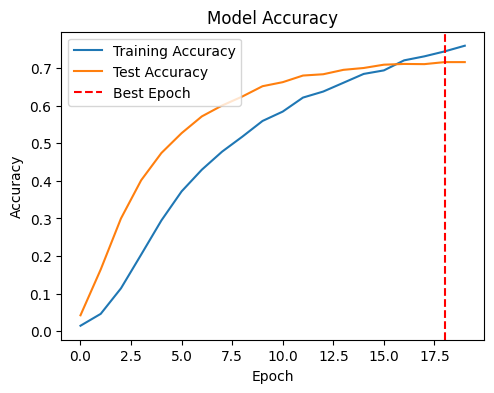

In [ ]:
# Plot training & test accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc3, label='Training Accuracy')
plt.plot(test_acc3, label='Test Accuracy')
plt.axvline(x=best_epoch3 - 1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

The test accuracy was higher than the training accuracy until the 16th epoch. From the 17th epoch, the training accuracy improved over the test accuracy.

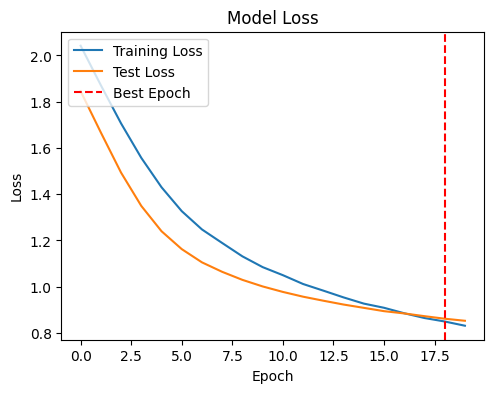

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss3, label='Training Loss')
plt.plot(test_loss3, label='Test Loss')
plt.axvline(x=best_epoch3 - 1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

The loss plot also showed the same trend. The model underfitted the data until the 17th epoch. After the 17th epoch, the trining loss was slightly lower than the test loss.

**Droupout rate = 0.1**

The model with dropout rate of 0.1 was created.

In [ ]:
# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Unfreeze some layers of the base model
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Fine-tune remaining layers
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Add new classification layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

predictions = Dense(breed_count, activation='softmax')(x)

# Create the new model
model = Model(base_model.input, outputs = predictions)

model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_focal_crossentropy', metrics=['accuracy'])

print(len(model.layers))

160


In [ ]:
# Model summary
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_12[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=2)

# epoch
epochs = 20

history4 = model.fit(train_data, validation_data=valid_data, epochs=epochs, callbacks=[early_stopping])

Epoch 1/20
256/256 [==============================] - 33s 92ms/step - loss: 1.9334 - accuracy: 0.0230 - val_loss: 1.8018 - val_accuracy: 0.0748
Epoch 2/20
256/256 [==============================] - 23s 91ms/step - loss: 1.6983 - accuracy: 0.1368 - val_loss: 1.5524 - val_accuracy: 0.2425
Epoch 3/20
256/256 [==============================] - 26s 101ms/step - loss: 1.4798 - accuracy: 0.3185 - val_loss: 1.3413 - val_accuracy: 0.3961
Epoch 4/20
256/256 [==============================] - 23s 91ms/step - loss: 1.3145 - accuracy: 0.4565 - val_loss: 1.2026 - val_accuracy: 0.4998
Epoch 5/20
256/256 [==============================] - 24s 95ms/step - loss: 1.1942 - accuracy: 0.5562 - val_loss: 1.1164 - val_accuracy: 0.5623
Epoch 6/20
256/256 [==============================] - 21s 82ms/step - loss: 1.1065 - accuracy: 0.6233 - val_loss: 1.0566 - val_accuracy: 0.6054
Epoch 7/20
256/256 [==============================] - 26s 100ms/step - loss: 1.0361 - accuracy: 0.6724 - val_loss: 1.0160 - val_accurac

In [ ]:
# Training/Test accuracy
train_acc4 = history4.history['accuracy']
train_loss4 = history4.history['loss']
test_acc4 = history4.history['val_accuracy']
test_loss4 = history4.history['val_loss']

# Find the epoch with the lowest test loss
best_epoch4 = test_loss4.index(min(test_loss4)) + 1
best_train_acc4 = train_acc4[best_epoch4 - 1]
best_train_loss4 = train_loss4[best_epoch4 - 1]
best_test_acc4 = test_acc4[best_epoch4 - 1]
best_test_loss4 = test_loss4[best_epoch4 - 1]

# Print the best epoch and corresponding training/test accuracy and loss
print(f"Best epoch: {best_epoch4}")
print(f"Best training accuracy at epoch {best_epoch4}: {best_train_acc4}")
print(f"Best training loss at epoch {best_epoch4}: {best_train_loss4}")
print(f"Best test accuracy at epoch {best_epoch4}: {best_test_acc4}")
print(f"Best test loss at epoch {best_epoch4}: {best_test_loss4}")

Best epoch: 20
Best training accuracy at epoch 20: 0.9235661029815674
Best training loss at epoch 20: 0.6889912486076355
Best test accuracy at epoch 20: 0.7325183153152466
Best test loss at epoch 20: 0.8046880960464478


The best epoch was 20. The best training and test accuracy were 92% and 73%. The best training and test loss were 0.69 and 0.80.

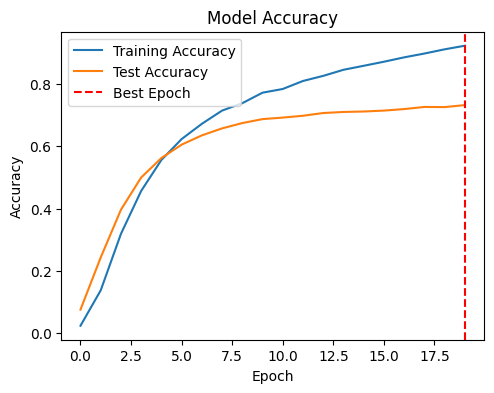

In [ ]:
# Plot training & test accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc4, label='Training Accuracy')
plt.plot(test_acc4, label='Test Accuracy')
plt.axvline(x=best_epoch4 - 1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

The test accuracy was little higher than training accuracy at the beginning. After some point, the training accuracy became higher than test accuracy.

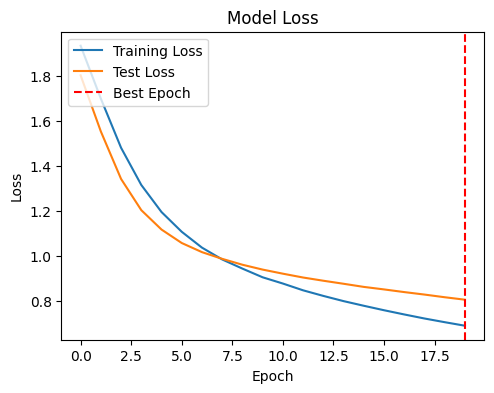

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss4, label='Training Loss')
plt.plot(test_loss4, label='Test Loss')
plt.axvline(x=best_epoch4 - 1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

The test loss was also lower than the training loss at the beginning, but the training loss became lower than the test loss.

#### Unfreeze all layers

**Dropout rate = 0.5**

The model unfreezing all layers with 0.5 dropout rate was created.

In [ ]:
# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Unfreeze all layers of the base model
base_model.trainable = True

# Add new classification layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(breed_count, activation='softmax')(x)

# Create the new model
model = Model(base_model.input, outputs = predictions)

model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_focal_crossentropy', metrics=['accuracy'])

print(len(model.layers))

160


In [ ]:
# Model summary
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_13[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=2)

# epoch
epochs = 20

history5 = model.fit(train_data, validation_data=valid_data, epochs=epochs, callbacks=[early_stopping])

Epoch 1/20
256/256 [==============================] - 68s 164ms/step - loss: 2.0471 - accuracy: 0.0131 - val_loss: 1.8595 - val_accuracy: 0.0357
Epoch 2/20
256/256 [==============================] - 41s 161ms/step - loss: 1.8727 - accuracy: 0.0445 - val_loss: 1.6860 - val_accuracy: 0.1482
Epoch 3/20
256/256 [==============================] - 38s 148ms/step - loss: 1.7044 - accuracy: 0.1136 - val_loss: 1.5040 - val_accuracy: 0.2870
Epoch 4/20
256/256 [==============================] - 41s 158ms/step - loss: 1.5490 - accuracy: 0.2022 - val_loss: 1.3502 - val_accuracy: 0.3980
Epoch 5/20
256/256 [==============================] - 40s 155ms/step - loss: 1.4127 - accuracy: 0.3027 - val_loss: 1.2325 - val_accuracy: 0.4738
Epoch 6/20
256/256 [==============================] - 41s 161ms/step - loss: 1.3102 - accuracy: 0.3825 - val_loss: 1.1501 - val_accuracy: 0.5394
Epoch 7/20
256/256 [==============================] - 39s 152ms/step - loss: 1.2241 - accuracy: 0.4532 - val_loss: 1.0872 - val_ac

In [ ]:
# Training/Test accuracy
train_acc5 = history5.history['accuracy']
train_loss5 = history5.history['loss']
test_acc5 = history5.history['val_accuracy']
test_loss5 = history5.history['val_loss']

# Find the epoch with the lowest test loss
best_epoch5 = test_acc5.index(max(test_acc5)) + 1
best_train_acc5 = train_acc5[best_epoch5 - 1]
best_train_loss5 = train_loss5[best_epoch5 - 1]
best_test_acc5 = test_acc5[best_epoch5 - 1]
best_test_loss5 = test_loss5[best_epoch5 - 1]

# Print the best epoch and corresponding training/test accuracy and loss
print(f"Best epoch: {best_epoch5}")
print(f"Best training accuracy at epoch {best_epoch5}: {best_train_acc5}")
print(f"Best training loss at epoch {best_epoch5}: {best_train_loss5}")
print(f"Best test accuracy at epoch {best_epoch5}: {best_test_acc5}")
print(f"Best test loss at epoch {best_epoch5}: {best_test_loss5}")

Best epoch: 20
Best training accuracy at epoch 20: 0.7932004332542419
Best training loss at epoch 20: 0.8007873296737671
Best test accuracy at epoch 20: 0.7393643260002136
Best test loss at epoch 20: 0.8264455199241638


The best epoch was also 20 and its training and test accuracy were about 79% and 74%. The training and test losses were 0.80 and 0.83.

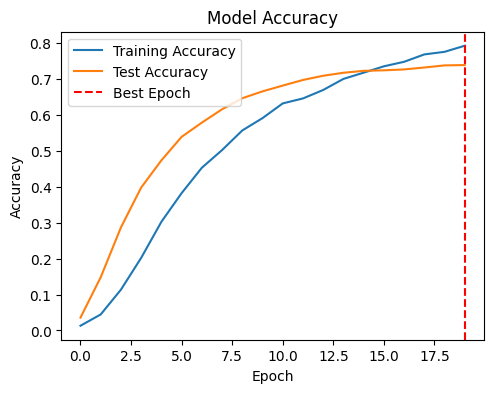

In [ ]:
# Plot training & test accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc5, label='Training Accuracy')
plt.plot(test_acc5, label='Test Accuracy')
plt.axvline(x=best_epoch5 - 1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

The model underfitted the data until the 15th epoch; the test accuracy was higher than the training accuracy. However, at the end, the training accuracy surpassed the test accuracy.

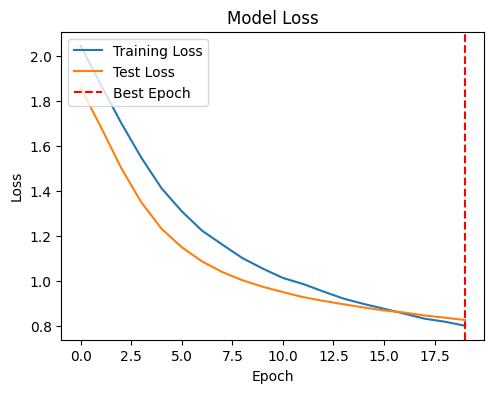

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss5, label='Training Loss')
plt.plot(test_loss5, label='Test Loss')
plt.axvline(x=best_epoch5 - 1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

The training loss was higher until the 17th epoch. However, the training loss became lower at the end.

**Dropout rate = 0.1**

The model with dropout rate of 0.1 was created.

In [ ]:
# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Unfreeze all layers of the base model
base_model.trainable = True

# Add new classification layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

predictions = Dense(breed_count, activation='softmax')(x)

# Create the new model
model = Model(base_model.input, outputs = predictions)

model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_focal_crossentropy', metrics=['accuracy'])

print(len(model.layers))

160


In [ ]:
# Model summary
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_14[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=2)

# epoch
epochs = 20

history6 = model.fit(train_data, validation_data=valid_data, epochs=epochs, callbacks=[early_stopping])

Epoch 1/20
256/256 [==============================] - 63s 156ms/step - loss: 1.9423 - accuracy: 0.0249 - val_loss: 1.7961 - val_accuracy: 0.0753
Epoch 2/20
256/256 [==============================] - 41s 158ms/step - loss: 1.7013 - accuracy: 0.1334 - val_loss: 1.5472 - val_accuracy: 0.2685
Epoch 3/20
256/256 [==============================] - 45s 176ms/step - loss: 1.4763 - accuracy: 0.3374 - val_loss: 1.3239 - val_accuracy: 0.4430
Epoch 4/20
256/256 [==============================] - 38s 148ms/step - loss: 1.2945 - accuracy: 0.4950 - val_loss: 1.1809 - val_accuracy: 0.5369
Epoch 5/20
256/256 [==============================] - 40s 156ms/step - loss: 1.1655 - accuracy: 0.5984 - val_loss: 1.0894 - val_accuracy: 0.5892
Epoch 6/20
256/256 [==============================] - 40s 156ms/step - loss: 1.0783 - accuracy: 0.6593 - val_loss: 1.0291 - val_accuracy: 0.6372
Epoch 7/20
256/256 [==============================] - 41s 159ms/step - loss: 1.0083 - accuracy: 0.7085 - val_loss: 0.9862 - val_ac

In [ ]:
# Training/Test accuracy
train_acc6 = history6.history['accuracy']
train_loss6 = history6.history['loss']
test_acc6 = history6.history['val_accuracy']
test_loss6 = history6.history['val_loss']

# Find the epoch with the lowest test loss
best_epoch6 = test_acc6.index(max(test_acc6)) + 1
best_train_acc6 = train_acc6[best_epoch6 - 1]
best_train_loss6 = train_loss6[best_epoch6 - 1]
best_test_acc6 = test_acc6[best_epoch6 - 1]
best_test_loss6 = test_loss6[best_epoch6 - 1]

# Print the best epoch and corresponding training/test accuracy and loss
print(f"Best epoch: {best_epoch6}")
print(f"Best training accuracy at epoch {best_epoch6}: {best_train_acc6}")
print(f"Best training loss at epoch {best_epoch6}: {best_train_loss6}")
print(f"Best test accuracy at epoch {best_epoch6}: {best_test_acc6}")
print(f"Best test loss at epoch {best_epoch6}: {best_test_loss6}")

Best epoch: 20
Best training accuracy at epoch 20: 0.9398312568664551
Best training loss at epoch 20: 0.6677272915840149
Best test accuracy at epoch 20: 0.7486552596092224
Best test loss at epoch 20: 0.7761932015419006


The best training and test accuracy were at the 20th epoch. There were 94% and 75% respectively. The best training and test looses were 0.67 and 0.78.

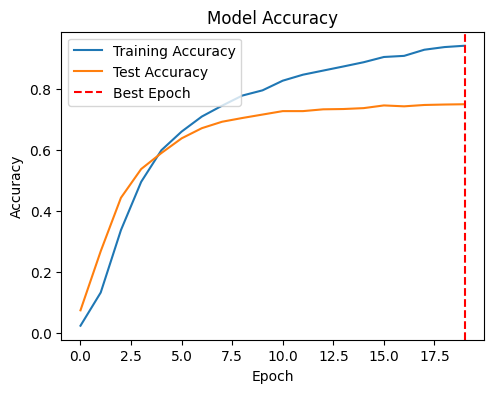

In [ ]:
# Plot training & test accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc6, label='Training Accuracy')
plt.plot(test_acc6, label='Test Accuracy')
plt.axvline(x=best_epoch6 - 1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

The training accuracy was slightly lower than the test accuracy. However, the training accuracy kept increasing and became higher than the test accuracy.

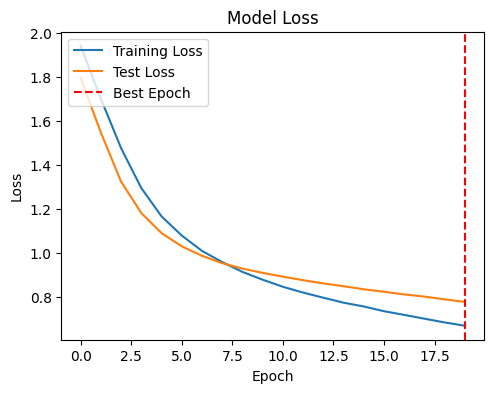

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss6, label='Training Loss')
plt.plot(test_loss6, label='Test Loss')
plt.axvline(x=best_epoch6 - 1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

Again, the training loss was higher than test loss at the beginning. However, the training loss became lower than the test loss.

Overall, the models with a dropout rate of 0.1 had better performances compared to the models with a dropout rate of 0.5. The model with freezing all layers had the best result; unfreezing all layers was the second, and freezing 100 layers was the last. Among the 6 models, even though the model overfitted the data, the model freezing all layers with a dropout rate of 0.1 had the best training and test accuracy.

### Xception Model

Xception model, which stands for "Extreme Inception," is a convolutional neural network that is based on the Inception architecture. It was proposed by François Chollet, the creator of the Keras library, in a paper titled "Xception: Deep Learning with Depthwise Separable Convolutions."

The main difference between Xception and Inception is the type of convolution operations they use. Xception uses depthwise separable convolutions, where the spatial and channel-wise correlations in the input are mapped separately. This is more efficient than the standard convolutions used in Inception.

Xception provides a better performance than Inception when it comes to large-scale image classification tasks. It achieves this by using fewer parameters and computations.



#### Freeze all layers

In [ ]:
# create the base pre-trained model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# add a global spatial average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)

# and a logistic layer
predictions = Dense(breed_count, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

# Train the model
xception_hist = model.fit(train_data, validation_data=valid_data, epochs=20, callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
256/256 [==============================] - 70s 245ms/step - loss: 3.5923 - accuracy: 0.2823 - val_loss: 2.1410 - val_accuracy: 0.6655
Epoch 2/20
256/256 [==============================] - 48s 188ms/step - loss: 1.5881 - accuracy: 0.6878 - val_loss: 1.0311 - val_accuracy: 0.7638
Epoch 3/20
256/256 [==============================] - 48s 188ms/step - loss: 1.0068 - accuracy: 0.7592 - val_loss: 0.8147 - val_accuracy: 0.7858
Epoch 4/20
256/256 [==============================] - 48s 187ms/step - loss: 0.8250 - accuracy: 0.7851 - val_loss: 0.7408 - val_accuracy: 0.7878
Epoch 5/20
256/256 [==============================] - 48s 188ms/step - loss: 0.7224 - accuracy: 0.7997 - val_loss: 0.7033 - val_accuracy: 0.7902
Epoch 6/20
256/256 [==============================] - 47s 184ms/step - loss: 0.6579 - accuracy: 0.8119 - val_loss: 0.6832 - val_accuracy: 0.7966
Epoch 7/20
256/256 [==============================] - 48s 189ms/step - loss: 0.6053 - accuracy: 0.8252 - val_loss: 0.6728 - val_ac

In [ ]:
# Training/Test accuracy
train_acc_xcep = xception_hist.history['accuracy']
train_loss_xcep = xception_hist.history['loss']
test_acc_xcep = xception_hist.history['val_accuracy']
test_loss_xcep = xception_hist.history['val_loss']

# Find the epoch with the lowest test loss
best_epoch_xcep = test_loss_xcep.index(min(test_loss_xcep)) + 1
best_train_acc_xcep = train_acc_xcep[best_epoch_xcep - 1]
best_train_loss_xcep = test_loss_xcep[best_epoch_xcep - 1]
best_test_acc_xcep = test_acc_xcep[best_epoch_xcep - 1]
best_test_loss_xcep = test_loss_xcep[best_epoch_xcep - 1]

# Print the best epoch and corresponding training/test accuracy and loss
print(f"Best epoch: {best_epoch_xcep}")
print(f"Best training accuracy at epoch {best_epoch_xcep}: {best_train_acc_xcep}")
print(f"Best training loss at epoch {best_epoch_xcep}: {best_train_loss_xcep}")
print(f"Best testing accuracy at epoch {best_epoch_xcep}: {best_test_acc_xcep}")
print(f"Best testing loss at epoch {best_epoch_xcep}: {best_test_loss_xcep}")

Best epoch: 10
Best training accuracy at epoch 10: 0.8533692359924316
Best training loss at epoch 10: 0.6617399454116821
Best testing accuracy at epoch 10: 0.7970660328865051
Best testing loss at epoch 10: 0.6617399454116821


The training accuracy is 85.34%, while the test accuracy is 79.71%. This indicates that the model is performing reasonably well on both the training and test datasets. However, there is a noticeable gap between the training and test accuracy, which suggests that the model might be slightly overfitting to the training data.

Both the training and test loss are 0.66 at the best epoch. This is a good sign as it indicates that the model's performance on the training and test datasets is consistent in terms of loss.

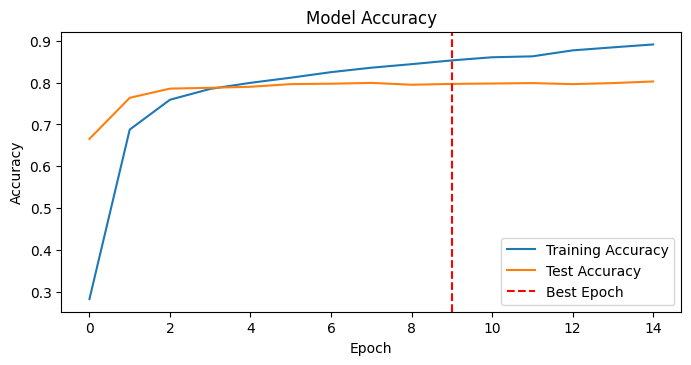

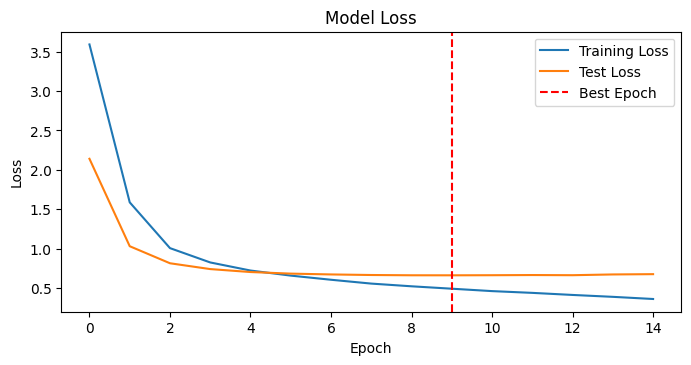

In [ ]:
# Plot training & test accuracy values
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(train_acc_xcep, label='Training Accuracy')
plt.plot(test_acc_xcep, label='Test Accuracy')
plt.axvline(x=best_epoch_xcep - 1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(train_loss_xcep, label='Training Loss')
plt.plot(test_loss_xcep, label='Test Loss')
plt.axvline(x=best_epoch_xcep - 1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

#### Freeze the first 100 layers

In [ ]:
# create the base pre-trained model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Unfreeze some layers of the base model
base_model.trainable = True
# Freeze the first 100 layers
for layer in base_model.layers[:100]:
    layer.trainable = False
# Fine-tune remaining layers
for layer in base_model.layers[100:]:
    layer.trainable = True

# add a global spatial average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)

# and a logistic layer
predictions = Dense(breed_count, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_4[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

# Train the model
xception_hist2 = model.fit(train_data, validation_data=valid_data, epochs=20, callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
256/256 [==============================] - 79s 265ms/step - loss: 3.0819 - accuracy: 0.3617 - val_loss: 1.3389 - val_accuracy: 0.7027
Epoch 2/20
256/256 [==============================] - 65s 254ms/step - loss: 1.0366 - accuracy: 0.7426 - val_loss: 0.8687 - val_accuracy: 0.7540
Epoch 3/20
256/256 [==============================] - 66s 256ms/step - loss: 0.5793 - accuracy: 0.8453 - val_loss: 0.8145 - val_accuracy: 0.7687
Epoch 4/20
256/256 [==============================] - 64s 248ms/step - loss: 0.3389 - accuracy: 0.9122 - val_loss: 0.7806 - val_accuracy: 0.7785
Epoch 5/20
256/256 [==============================] - 65s 252ms/step - loss: 0.1894 - accuracy: 0.9565 - val_loss: 0.7860 - val_accuracy: 0.7760
Epoch 6/20
256/256 [==============================] - 63s 246ms/step - loss: 0.1127 - accuracy: 0.9813 - val_loss: 0.8111 - val_accuracy: 0.7736
Epoch 7/20
256/256 [==============================] - 63s 247ms/step - loss: 0.0682 - accuracy: 0.9906 - val_loss: 0.8307 - val_ac

In [ ]:
# Training/Test accuracy
train_acc_xcep2 = xception_hist2.history['accuracy']
train_loss_xcep2 = xception_hist2.history['loss']
test_acc_xcep2 = xception_hist2.history['val_accuracy']
test_loss_xcep2 = xception_hist2.history['val_loss']

# Find the epoch with the lowest test loss
best_epoch_xcep2 = test_loss_xcep2.index(min(test_loss_xcep2)) + 1
best_train_acc_xcep2 = train_acc_xcep2[best_epoch_xcep2 - 1]
best_train_loss_xcep2 = test_loss_xcep2[best_epoch_xcep2 - 1]
best_test_acc_xcep2 = test_acc_xcep2[best_epoch_xcep2 - 1]
best_test_loss_xcep2 = test_loss_xcep2[best_epoch_xcep2 - 1]

# Print the best epoch and corresponding training/test accuracy and loss
print(f"Best epoch: {best_epoch_xcep2}")
print(f"Best training accuracy at epoch {best_epoch_xcep2}: {best_train_acc_xcep2}")
print(f"Best training loss at epoch {best_epoch_xcep2}: {best_train_loss_xcep2}")
print(f"Best testing accuracy at epoch {best_epoch_xcep2}: {best_test_acc_xcep2}")
print(f"Best testing loss at epoch {best_epoch_xcep2}: {best_test_loss_xcep2}")

Best epoch: 4
Best training accuracy at epoch 4: 0.9121927618980408
Best training loss at epoch 4: 0.7806093692779541
Best testing accuracy at epoch 4: 0.7784841060638428
Best testing loss at epoch 4: 0.7806093692779541


We can see that the training accuracy is higher than first model, which is 91.22%, while testing accuracy becomes lower than model 1.


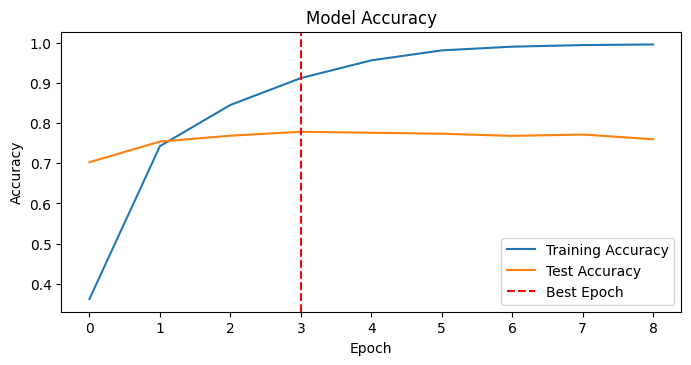

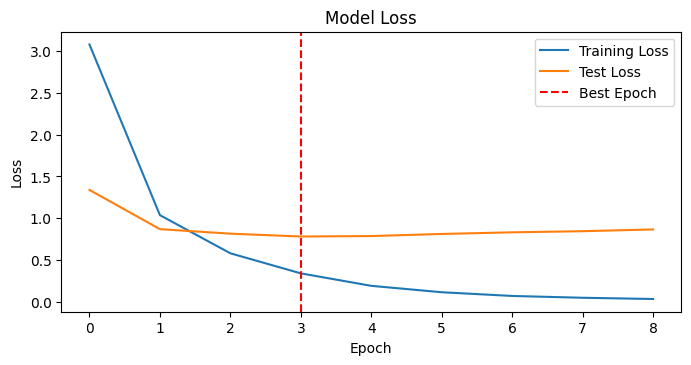

In [ ]:
# Plot training & test accuracy values
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(train_acc_xcep2, label='Training Accuracy')
plt.plot(test_acc_xcep2, label='Test Accuracy')
plt.axvline(x=best_epoch_xcep2 - 1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(train_loss_xcep2, label='Training Loss')
plt.plot(test_loss_xcep2, label='Test Loss')
plt.axvline(x=best_epoch_xcep2 - 1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

#### Unfreeze all layers

###### Dropout rate = 0.5

In [ ]:
# create the base pre-trained model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Unfreeze all layers of the base model
base_model.trainable = True

# add a global spatial average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)

# and a logistic layer
predictions = Dense(breed_count, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

# Train the model
xception_hist3 = model.fit(train_data, validation_data=valid_data, epochs=20, callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
256/256 [==============================] - 183s 584ms/step - loss: 2.9850 - accuracy: 0.3729 - val_loss: 1.3673 - val_accuracy: 0.7335
Epoch 2/20
256/256 [==============================] - 140s 548ms/step - loss: 0.8815 - accuracy: 0.7760 - val_loss: 0.8326 - val_accuracy: 0.7697
Epoch 3/20
256/256 [==============================] - 138s 538ms/step - loss: 0.3864 - accuracy: 0.8990 - val_loss: 0.7726 - val_accuracy: 0.7760
Epoch 4/20
256/256 [==============================] - 138s 540ms/step - loss: 0.1805 - accuracy: 0.9596 - val_loss: 0.7559 - val_accuracy: 0.7839
Epoch 5/20
256/256 [==============================] - 137s 537ms/step - loss: 0.0963 - accuracy: 0.9808 - val_loss: 0.7582 - val_accuracy: 0.7888
Epoch 6/20
256/256 [==============================] - 136s 533ms/step - loss: 0.0549 - accuracy: 0.9914 - val_loss: 0.7821 - val_accuracy: 0.7795
Epoch 7/20
256/256 [==============================] - 136s 533ms/step - loss: 0.0378 - accuracy: 0.9943 - val_loss: 0.7685 -

In [ ]:
# Training/Test accuracy
train_acc_xcep3 = xception_hist3.history['accuracy']
train_loss_xcep3 = xception_hist3.history['loss']
test_acc_xcep3 = xception_hist3.history['val_accuracy']
test_loss_xcep3 = xception_hist3.history['val_loss']

# Find the epoch with the lowest test loss
best_epoch_xcep3 = test_loss_xcep3.index(min(test_loss_xcep3)) + 1
best_train_acc_xcep3 = train_acc_xcep3[best_epoch_xcep3 - 1]
best_train_loss_xcep3 = test_loss_xcep3[best_epoch_xcep3 - 1]
best_test_acc_xcep3 = test_acc_xcep3[best_epoch_xcep3 - 1]
best_test_loss_xcep3 = test_loss_xcep3[best_epoch_xcep3 - 1]

# Print the best epoch and corresponding training/test accuracy and loss
print(f"Best epoch: {best_epoch_xcep3}")
print(f"Best training accuracy at epoch {best_epoch_xcep3}: {best_train_acc_xcep3}")
print(f"Best training loss at epoch {best_epoch_xcep3}: {best_train_loss_xcep3}")
print(f"Best testing accuracy at epoch {best_epoch_xcep3}: {best_test_acc_xcep3}")
print(f"Best testing loss at epoch {best_epoch_xcep3}: {best_test_loss_xcep3}")

Best epoch: 4
Best training accuracy at epoch 4: 0.9596428871154785
Best training loss at epoch 4: 0.7558966279029846
Best testing accuracy at epoch 4: 0.7838630676269531
Best testing loss at epoch 4: 0.7558966279029846


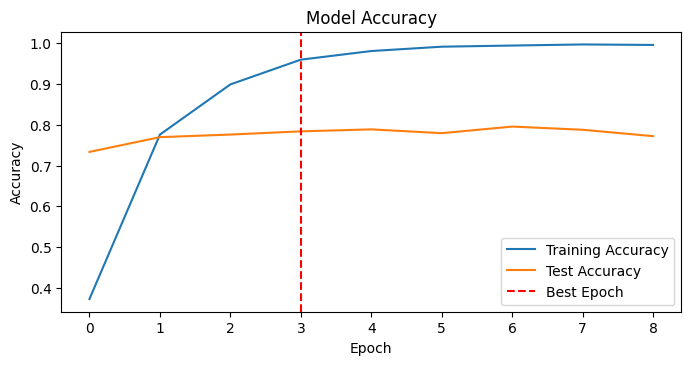

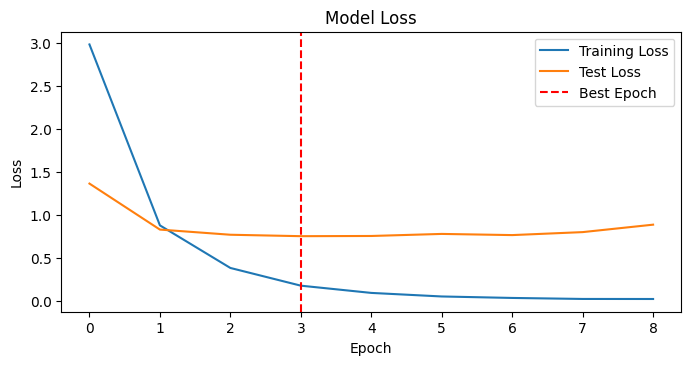

In [ ]:
# Plot training & test accuracy values
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(train_acc_xcep3, label='Training Accuracy')
plt.plot(test_acc_xcep3, label='Test Accuracy')
plt.axvline(x=best_epoch_xcep3 - 1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 2)
plt.plot(train_loss_xcep3, label='Training Loss')
plt.plot(test_loss_xcep3, label='Test Loss')
plt.axvline(x=best_epoch_xcep3 - 1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

##### Adjust Dropout rate to 0.2

In [ ]:
# create the base pre-trained model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Unfreeze all layers of the base model
base_model.trainable = True

# add a global spatial average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dropout(0.2)(x) #adjust dropout rate from 0.5 to 0.2
x = Dense(256, activation='relu')(x)

# and a logistic layer
predictions = Dense(breed_count, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

# Train the model
xception_hist4 = model.fit(train_data, validation_data=valid_data, epochs=20, callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
256/256 [==============================] - 165s 554ms/step - loss: 2.4700 - accuracy: 0.4932 - val_loss: 1.2653 - val_accuracy: 0.7311
Epoch 2/20
256/256 [==============================] - 144s 561ms/step - loss: 0.6328 - accuracy: 0.8418 - val_loss: 0.8017 - val_accuracy: 0.7760
Epoch 3/20
256/256 [==============================] - 140s 548ms/step - loss: 0.2254 - accuracy: 0.9521 - val_loss: 0.7584 - val_accuracy: 0.7883
Epoch 4/20
256/256 [==============================] - 136s 532ms/step - loss: 0.1031 - accuracy: 0.9801 - val_loss: 0.7652 - val_accuracy: 0.7824
Epoch 5/20
256/256 [==============================] - 137s 536ms/step - loss: 0.0498 - accuracy: 0.9923 - val_loss: 0.7870 - val_accuracy: 0.7829
Epoch 6/20
256/256 [==============================] - 137s 535ms/step - loss: 0.0280 - accuracy: 0.9969 - val_loss: 0.7994 - val_accuracy: 0.7868
Epoch 7/20
256/256 [==============================] - 137s 536ms/step - loss: 0.0203 - accuracy: 0.9972 - val_loss: 0.8122 -

In [ ]:
# Training/Test accuracy
train_acc_xcep4 = xception_hist4.history['accuracy']
train_loss_xcep4 = xception_hist4.history['loss']
test_acc_xcep4 = xception_hist4.history['val_accuracy']
test_loss_xcep4 = xception_hist4.history['val_loss']

# Find the epoch with the lowest test loss
best_epoch_xcep4 = test_loss_xcep4.index(min(test_loss_xcep4)) + 1
best_train_acc_xcep4 = train_acc_xcep4[best_epoch_xcep4 - 1]
best_train_loss_xcep4 = test_loss_xcep4[best_epoch_xcep4 - 1]
best_test_acc_xcep4 = test_acc_xcep4[best_epoch_xcep4 - 1]
best_test_loss_xcep4 = test_loss_xcep4[best_epoch_xcep4 - 1]

# Print the best epoch and corresponding training/test accuracy and loss
print(f"Best epoch: {best_epoch_xcep4}")
print(f"Best training accuracy at epoch {best_epoch_xcep4}: {best_train_acc_xcep4}")
print(f"Best training loss at epoch {best_epoch_xcep4}: {best_train_loss_xcep4}")
print(f"Best testing accuracy at epoch {best_epoch_xcep4}: {best_test_acc_xcep4}")
print(f"Best testing loss at epoch {best_epoch_xcep4}: {best_test_loss_xcep4}")

Best epoch: 3
Best training accuracy at epoch 3: 0.9520606398582458
Best training loss at epoch 3: 0.7583817839622498
Best testing accuracy at epoch 3: 0.7882640361785889
Best testing loss at epoch 3: 0.7583817839622498


Based on the results, Model 4 is the best model. Here are the reasons:
* Highest Test Accuracy: Model 4 has the highest test accuracy at 78.83%, indicating better generalization to unseen data.
* Comparable Training and Test Loss: Model 4 has a training and test loss of 0.76, which is consistent with Models 2 and 3 but better than Model 1.
* Early Convergence: Model 4 achieved its best performance at epoch 3, suggesting that it converged faster than the other models.

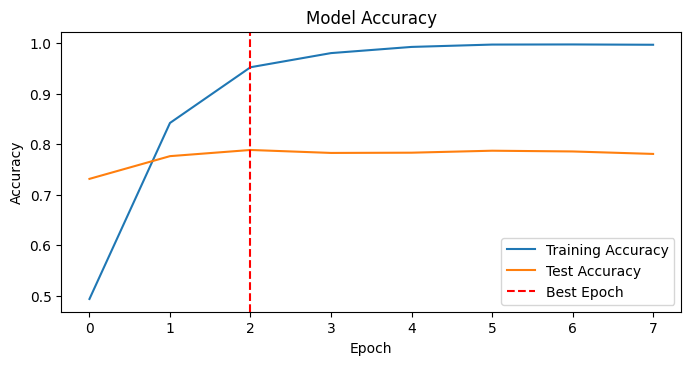

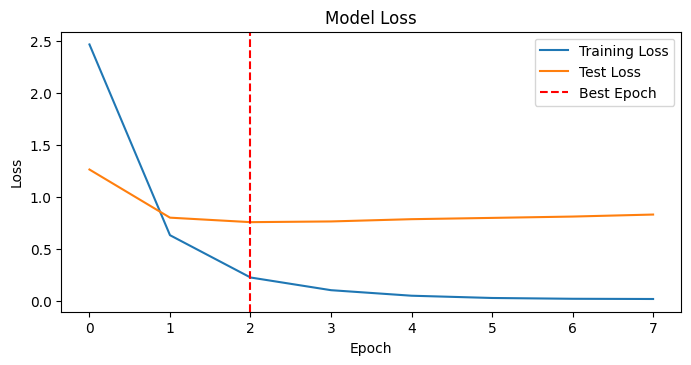

In [ ]:
# Plot training & test accuracy values
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(train_acc_xcep4, label='Training Accuracy')
plt.plot(test_acc_xcep4, label='Test Accuracy')
plt.axvline(x=best_epoch_xcep4 - 1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(train_loss_xcep4, label='Training Loss')
plt.plot(test_loss_xcep4, label='Test Loss')
plt.axvline(x=best_epoch_xcep4 - 1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

## 5. Transfer Learning Using Feature Extraction

In the context of transfer learning, feature extraction involves removing the last layer (or several layers) of the model, running our new data through the rest of the model, and training a new layer (or several layers) that uses the output of the pre-trained model as input.

By using transfer learning, we can leverage the low-level feature extraction capabilities learned from large datasets, and adapt it to our dataset. This can improve performance, especially when the new task is similar to the task the model was originally trained on.

### Loading and preparing data

First, load the image data from a directory and also the labels dataframe.

In [ ]:
def get_num_files(path):
    '''
    Counts the number of files in a folder.
    '''
    if not os.path.exists(path):
        return 0
    return sum([len(files) for r, d, files in os.walk(path)])

In [ ]:
image_size = (224,224,3)
train_dir = 'train'
data_size = get_num_files(train_dir)
print('Data samples size: ', data_size)

Data samples size:  10222


In [ ]:
labels_dataframe = pd.read_csv('labels.csv')

We used the get_features function to extract features from the images using the pre-trained models. This function creates a new model that includes all the layers of the pre-trained model up to the global average pooling layer. It is used to predict on the input data, and the output of this prediction (the feature maps) are returned.

In [ ]:
def get_features(model_name, data_preprocessor, input_size, data):
    '''
    1- Create a feature extractor to extract features from the data.
    2- Returns the extracted features and the feature extractor.
    '''
    #Prepare pipeline.
    input_layer = Input(input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    #Extract feature.
    feature_maps = feature_extractor.predict(data, batch_size=32, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [ ]:
#Create list of alphabetically sorted labels.
dog_breeds = sorted(list(set(labels_dataframe['breed'])))
n_classes = len(dog_breeds)
print(n_classes)

120


In [ ]:
class_to_num = dict(zip(dog_breeds, range(n_classes)))

We defined another function images_to_array to read data and then perform data preprocessing.

In [ ]:
def images_to_array(data_dir, labels_dataframe, img_size = (224,224,3)):
    '''
    1- Read image samples from certain directory.
    2- Resize it, then stack them into one big numpy array.
    3- Read sample's label form the labels dataframe.
    4- One hot encode labels array.
    5- Shuffle Data and label arrays.
    '''
    images_names = labels_dataframe['id']
    images_labels = labels_dataframe['breed']
    data_size = len(images_names)
    #initailize output arrays.
    X = np.zeros([data_size, img_size[0], img_size[1], img_size[2]], dtype=np.uint8)
    y = np.zeros([data_size,1], dtype=np.uint8)
    #read data and lables.
    for i in tqdm(range(data_size)):
        image_name = images_names[i]
        img_dir = os.path.join(data_dir, image_name+'.jpg')
        img_pixels = load_img(img_dir, target_size=img_size)
        X[i] = img_pixels

        image_breed = images_labels[i]
        y[i] = class_to_num[image_breed]

    #One hot encoder
    y = to_categorical(y)
    #shuffle
    ind = np.random.permutation(data_size)
    X = X[ind]
    y = y[ind]
    print('Ouptut Data Size: ', X.shape)
    print('Ouptut Label Size: ', y.shape)
    return X, y

In [ ]:
X, y = images_to_array(train_dir, labels_dataframe)

100%|██████████| 10222/10222 [00:17<00:00, 589.69it/s]


Ouptut Data Size:  (10222, 224, 224, 3)
Ouptut Label Size:  (10222, 120)


### Downloading Models

Features were extracted using four different pre-trained models and concatenating these features together. This is a form of model stacking, where the predictions of multiple models are combined to improve the overall performance.

In [ ]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  image_size, X)


320/320 [==============================] - 24s 71ms/step
Feature maps shape:  (10222, 2048)


In [ ]:
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 image_size, X)

320/320 [==============================] - 42s 117ms/step
Feature maps shape:  (10222, 2048)


In [ ]:
# Extract features using NASNetLarge as extractor.
from keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input
nasnet_features = get_features(NASNetLarge,
                               nasnet_preprocessor,
                               image_size, X)

320/320 [==============================] - 121s 351ms/step
Feature maps shape:  (10222, 4032)


In [ ]:
# Extract features using InceptionResNetV2 as extractor.
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   image_size, X)

320/320 [==============================] - 57s 159ms/step
Feature maps shape:  (10222, 1536)


In [ ]:
final_features = np.concatenate([inception_features,
                                 xception_features,
                                 nasnet_features,
                                 inc_resnet_features,], axis=-1)
print('Final feature maps shape', final_features.shape)

Final feature maps shape (10222, 9664)


### Spliting the dataset into train and test set

The final features and y are split into train and test set, stratifying with y.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final_features, y, test_size=0.2, stratify=y, random_state=42)

### Training model

Therefore, We are going to create a new model (a simple dense network) that takes the extracted features as input and outputs a prediction for each class. This model is trained on the training data and evaluated on the test data.

In [ ]:
#Prepare call backs
EarlyStop_callback = EarlyStopping(monitor='val_accuracy', verbose=1,mode = 'max', patience=15, restore_best_weights=True)
my_callback=[EarlyStop_callback]

In [ ]:
model_1 = Sequential([
    InputLayer(X_train.shape[1:]),
    Dropout(0.7),
    Dense(n_classes, activation='softmax', kernel_regularizer=l2(0.001)
         )])

optimizer = Adam(learning_rate = 0.0001)
model_1.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Train simple DNN on extracted features.
history_1 = model_1.fit(
            X_train, y_train,
            batch_size= 64,
            epochs=100,
            validation_data=(X_test, y_test),
            callbacks=my_callback
                       )

Epoch 1/100
128/128 [==============================] - 1s 7ms/step - loss: 3.0355 - accuracy: 0.4110 - val_loss: 0.9292 - val_accuracy: 0.8465
Epoch 2/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0462 - accuracy: 0.7926 - val_loss: 0.7232 - val_accuracy: 0.8645
Epoch 3/100
128/128 [==============================] - 1s 5ms/step - loss: 0.8416 - accuracy: 0.8285 - val_loss: 0.6859 - val_accuracy: 0.8699
Epoch 4/100
128/128 [==============================] - 1s 5ms/step - loss: 0.7414 - accuracy: 0.8534 - val_loss: 0.6729 - val_accuracy: 0.8714
Epoch 5/100
128/128 [==============================] - 1s 5ms/step - loss: 0.6778 - accuracy: 0.8689 - val_loss: 0.6736 - val_accuracy: 0.8714
Epoch 6/100
128/128 [==============================] - 1s 5ms/step - loss: 0.6459 - accuracy: 0.8756 - val_loss: 0.6671 - val_accuracy: 0.8743
Epoch 7/100
128/128 [==============================] - 1s 5ms/step - loss: 0.6020 - accuracy: 0.8868 - val_loss: 0.6630 - val_accuracy: 0.8724

The highest validation accuracy is 87.78%, which was improved compared to the transfer learning models from part 4.

In [ ]:
loss, accuracy = model_1.evaluate(X_test, y_test, verbose=0)
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  0.6503086090087891
accuracy:  0.8777506351470947


Then we evaluated the data and got the accuracy of 87.78%, and loss is about 0.65.

History data were stored into a data frame to plot the model accuracy and loss.

In [ ]:
history_data = history_1.history

loss_df_1 = pd.DataFrame(history_data)
loss_df_1

,loss,accuracy,val_loss,val_accuracy
0,3.035510,0.411031,0.929187,0.846455
1,1.046160,0.792589,0.723171,0.864548
2,0.841600,0.828543,0.685891,0.869927
3,0.741429,0.853369,0.672930,0.871394
4,0.677809,0.868901,0.673632,0.871394
5,0.645900,0.875627,0.667095,0.874328
6,0.602023,0.886756,0.663023,0.872372
7,0.574172,0.893726,0.659672,0.869927
8,0.551813,0.897151,0.657901,0.875306
9,0.514494,0.913416,0.652900,0.873839


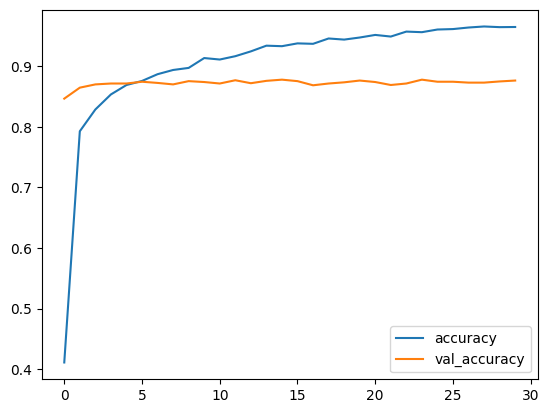

In [ ]:
loss_df_1[['accuracy','val_accuracy']].plot()
plt.legend(loc='lower right')
plt.show()

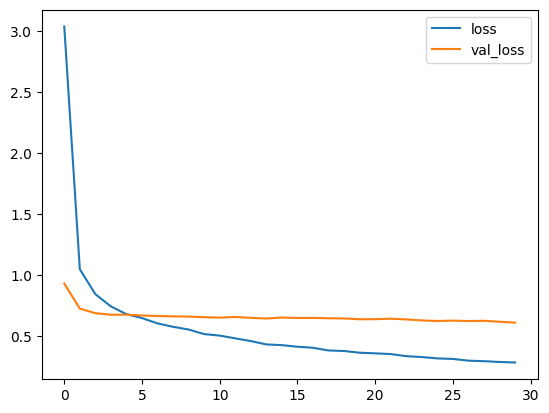

In [ ]:
loss_df_1[['loss','val_loss']].plot()
plt.show()

We can there is fluctuation in the validation accuracy and loss curves, the training accuracy and training loss are climbing and dropping steadily respectively.